# CA4015 Application Domains Assignments
For this assignment, I will be analysis my personal data that I have gathered from SleepScore, Fitbit and CBT Thought Diary

In [1]:
import numpy as np
import pandas as pd
import os
from datetime import datetime as dt
from pandas_profiling import ProfileReport
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Image
%matplotlib inline

## Data Importing, Cleaning and Feature Engineering

In [2]:
first_date, last_date = '2022-10-01', '2022-11-25'

In [3]:
def get_df(target_csv, category):
        #raw_df is a DataFrame that contains all the messy data in the original .csv file
    raw_df = pd.read_csv(target_csv,names = list(range(10)), skip_blank_lines = False)
    
        #"start" denotes the index where the data in the desired category begins
    start = int(np.where(raw_df[0] == category)[0] + 1)
    
        #"blank_separators" is a list of indices where the first column value is null, meaning the end of a category
    blank_separators = np.where(raw_df[0].isnull())[0]
    
        #"stop" finds the first value in this list comprehension of "blank_separators" that comes after the "start" index
    stop = blank_separators[blank_separators > start][0] - 1 if len(
        blank_separators[blank_separators > start]) > 0 else len(raw_df) - 1
    return(pd.read_csv(target_csv, skiprows = start, nrows = stop-start))

In [4]:
fitbit = [file for file in os.listdir('../data/') if 'fitbit' in file]

### Activity Data

In [5]:
# Read in fitbit data 
path = '../data/'
dfs = [get_df(path + file, 'Activities') for file in fitbit]
df_activity = pd.concat(dfs).reset_index(drop=True).sort_values('Date')

In [6]:
df_activity.head()

,Date,Calories Burned,Steps,Distance,Floors,Minutes Sedentary,Minutes Lightly Active,Minutes Fairly Active,Minutes Very Active,Activity Calories
0,2022-10-01,"3,068","9,944",7.25,19,464,379,4,6,"1,660"
1,2022-10-02,"2,979","10,925",8.01,19,577,292,17,26,"1,504"
2,2022-10-03,"3,496","12,709",9.26,12,523,390,28,12,"2,143"
3,2022-10-04,"2,769","9,808",7.17,17,752,209,21,12,"1,242"
4,2022-10-05,"3,146","12,934",9.44,16,729,246,28,37,"1,632"


In [7]:
df_activity.info();

<class 'pandas.core.frame.DataFrame'>
Int64Index: 56 entries, 0 to 55
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Date                    56 non-null     object 
 1   Calories Burned         56 non-null     object 
 2   Steps                   56 non-null     object 
 3   Distance                56 non-null     float64
 4   Floors                  56 non-null     int64  
 5   Minutes Sedentary       56 non-null     object 
 6   Minutes Lightly Active  56 non-null     int64  
 7   Minutes Fairly Active   56 non-null     int64  
 8   Minutes Very Active     56 non-null     int64  
 9   Activity Calories       56 non-null     object 
dtypes: float64(1), int64(4), object(5)
memory usage: 4.8+ KB


#### Steps to take
- Rename columns to pep8 style
- Date is an object but should be in datetime format
- CaloriesBurned, Steps, SedentaryMinutes, ActivityCalories need to have commas removed meaning 1,000 goes to 1000
- The above columns are objects but should be int64
- Create column Day for day of the week
- Filter out days when I didn't use the watch or it was dead by looking for very low activity

In [8]:
# Renamed columns using PEP8 style
df_activity.columns = ['Date', 'CaloriesBurned', 'Steps', 'Distance', 'Floors',
       'SedentaryMinutes', 'LightlyActiveMinutes', 'FairlyActiveMinutes',
       'VeryActiveMinutes', 'ActivityCalories']

In [9]:
# Important to specify datetime format to mitigate warnings
df_activity.Date = pd.to_datetime(df_activity.Date)

In [10]:
def remove_comma(x:str):
    '''
    remove_comma
    
    This function removes the comma from number strings to prepare them for conversion to int
    
    x is a string
    
    Examples
    IN:
    x = '1,000'
    remove_comma(x)
    
    OUT:
    1000
    
    IN:
    df[column].apply(remove_comma)
    '''
    return x[:-4] + x[-3:] if len(x) > 3 else x

In [11]:
# All these columns are objects and now need to be converted to int
for column in ['CaloriesBurned', 'Steps', 'SedentaryMinutes', 'ActivityCalories']:
    df_activity[column] = df_activity[column].apply(remove_comma)
    df_activity[column] = pd.to_numeric(df_activity[column])

In [12]:
# Create Day column
df_activity['Day'] = df_activity['Date'].dt.day_name()

##### Visual Inspection
To remove days that I didn't have the watch I need to search for low activity, the easiest way to do this is visualise the distribution of steps

In [13]:
pwd

'C:\\Users\\Diarmuid\\Documents\\dcu\\final-year\\ca4016_application_domains\\notebooks'

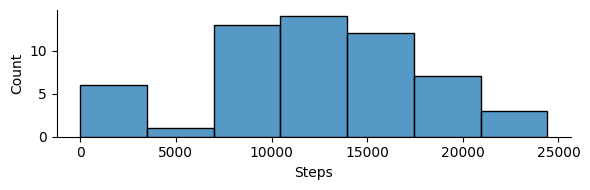

In [14]:
x = 'Steps'
sns.displot(data=df_activity, x='Steps', aspect=3, height=2)
plt.savefig(f'./../visuals/{x}.png');

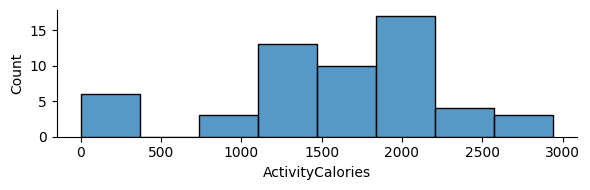

In [15]:
x = 'ActivityCalories'
sns.displot(data=df_activity, x=x, aspect=3, height=2)
plt.savefig(f'./../visuals/{x}.png');

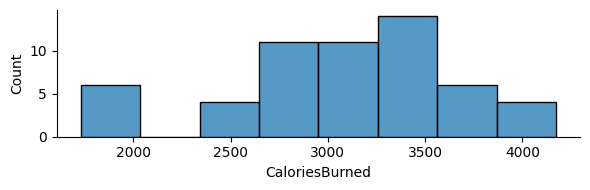

In [16]:
x = 'CaloriesBurned'
sns.displot(data=df_activity, x=x, aspect=3, height=2)
plt.savefig(f'./../visuals/{x}.png');

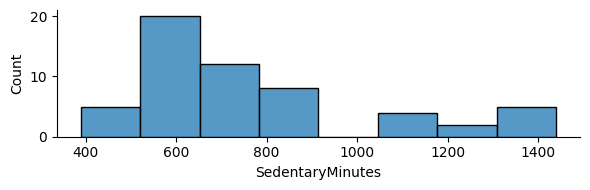

In [17]:
x = 'SedentaryMinutes'
sns.displot(data=df_activity, x=x, aspect=3, height=2)
plt.savefig(f'./../visuals/{x}.png');

We can see there are 6 (possibly 7) days where I wasn't using the watch. These need to be first inspected then removed.

In [18]:
df_activity.sort_values('Steps')[:10]

,Date,CaloriesBurned,Steps,Distance,Floors,SedentaryMinutes,LightlyActiveMinutes,FairlyActiveMinutes,VeryActiveMinutes,ActivityCalories,Day
8,2022-10-09,1729,0,0.00,0,1440,0,0,0,0,Sunday
9,2022-10-10,1729,0,0.00,0,1440,0,0,0,0,Monday
6,2022-10-07,1729,0,0.00,0,1440,0,0,0,0,Friday
7,2022-10-08,1729,0,0.00,0,1440,0,0,0,0,Saturday
10,2022-10-11,1776,184,0.13,0,1427,13,0,0,45,Tuesday
5,2022-10-06,1890,1873,1.48,5,879,40,0,0,195,Thursday
15,2022-10-16,2641,6239,4.73,8,787,169,11,25,1029,Sunday
22,2022-10-23,2403,7193,5.25,6,1260,137,25,18,859,Sunday
21,2022-10-22,2628,7800,5.69,12,707,301,9,0,1198,Saturday
32,2022-11-02,3058,7960,5.96,30,585,183,43,49,1563,Wednesday


In [19]:
df_activity = df_activity.sort_values('Steps').iloc[6:,:].sort_values('Date')

The records from 6/10 to 11/10 were a few days when I didn't have my fitbit as I temporarily misplaced my charger.

In [20]:
for col in df_activity.select_dtypes(include=['float', 'int']):
    df_activity[col + '_R7DM'] = df_activity[col].rolling(7, 1).mean()

#### Steps Completed
- ~Rename columns to pep8 style~
- ~Date is an object but should be in datetime format~
- ~CaloriesBurned, Steps, SedentaryMinutes, ActivityCalories need to have commas removed meaning 1,000 goes to 1000~
- ~The above columns are objects but should be int64~
- ~Added Day column~
- ~Removed invalid days~

In [21]:
df_activity.head()

,Date,CaloriesBurned,Steps,Distance,Floors,SedentaryMinutes,LightlyActiveMinutes,FairlyActiveMinutes,VeryActiveMinutes,ActivityCalories,Day,CaloriesBurned_R7DM,Steps_R7DM,Distance_R7DM,Floors_R7DM,SedentaryMinutes_R7DM,LightlyActiveMinutes_R7DM,FairlyActiveMinutes_R7DM,VeryActiveMinutes_R7DM,ActivityCalories_R7DM
0,2022-10-01,3068,9944,7.25,19,464,379,4,6,1660,Saturday,3068.0,9944.000000,7.250000,19.000000,464.000000,379.000000,4.000000,6.000000,1660.00
1,2022-10-02,2979,10925,8.01,19,577,292,17,26,1504,Sunday,3023.5,10434.500000,7.630000,19.000000,520.500000,335.500000,10.500000,16.000000,1582.00
2,2022-10-03,3496,12709,9.26,12,523,390,28,12,2143,Monday,3181.0,11192.666667,8.173333,16.666667,521.333333,353.666667,16.333333,14.666667,1769.00
3,2022-10-04,2769,9808,7.17,17,752,209,21,12,1242,Tuesday,3078.0,10846.500000,7.922500,16.750000,579.000000,317.500000,17.500000,14.000000,1637.25
4,2022-10-05,3146,12934,9.44,16,729,246,28,37,1632,Wednesday,3091.6,11264.000000,8.226000,16.600000,609.000000,303.200000,19.600000,18.600000,1636.20


In [22]:
df_activity.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50 entries, 0 to 55
Data columns (total 20 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Date                       50 non-null     datetime64[ns]
 1   CaloriesBurned             50 non-null     int64         
 2   Steps                      50 non-null     int64         
 3   Distance                   50 non-null     float64       
 4   Floors                     50 non-null     int64         
 5   SedentaryMinutes           50 non-null     int64         
 6   LightlyActiveMinutes       50 non-null     int64         
 7   FairlyActiveMinutes        50 non-null     int64         
 8   VeryActiveMinutes          50 non-null     int64         
 9   ActivityCalories           50 non-null     int64         
 10  Day                        50 non-null     object        
 11  CaloriesBurned_R7DM        50 non-null     float64       
 12  Steps_R7DM

report_activity = ProfileReport(df_activity, vars={"num": {"low_categorical_threshold": 0}})
report_activity.to_file('../reports/report_activity.html')

ax, fig = plt.subplots(figsize=(15, 15))
sns.heatmap(report_activity.description_set["correlations"]['spearman'], annot=True, cmap="rocket_r")
x = 'Activity_Heatmap'
plt.savefig(f'./../visuals/{x}.png');

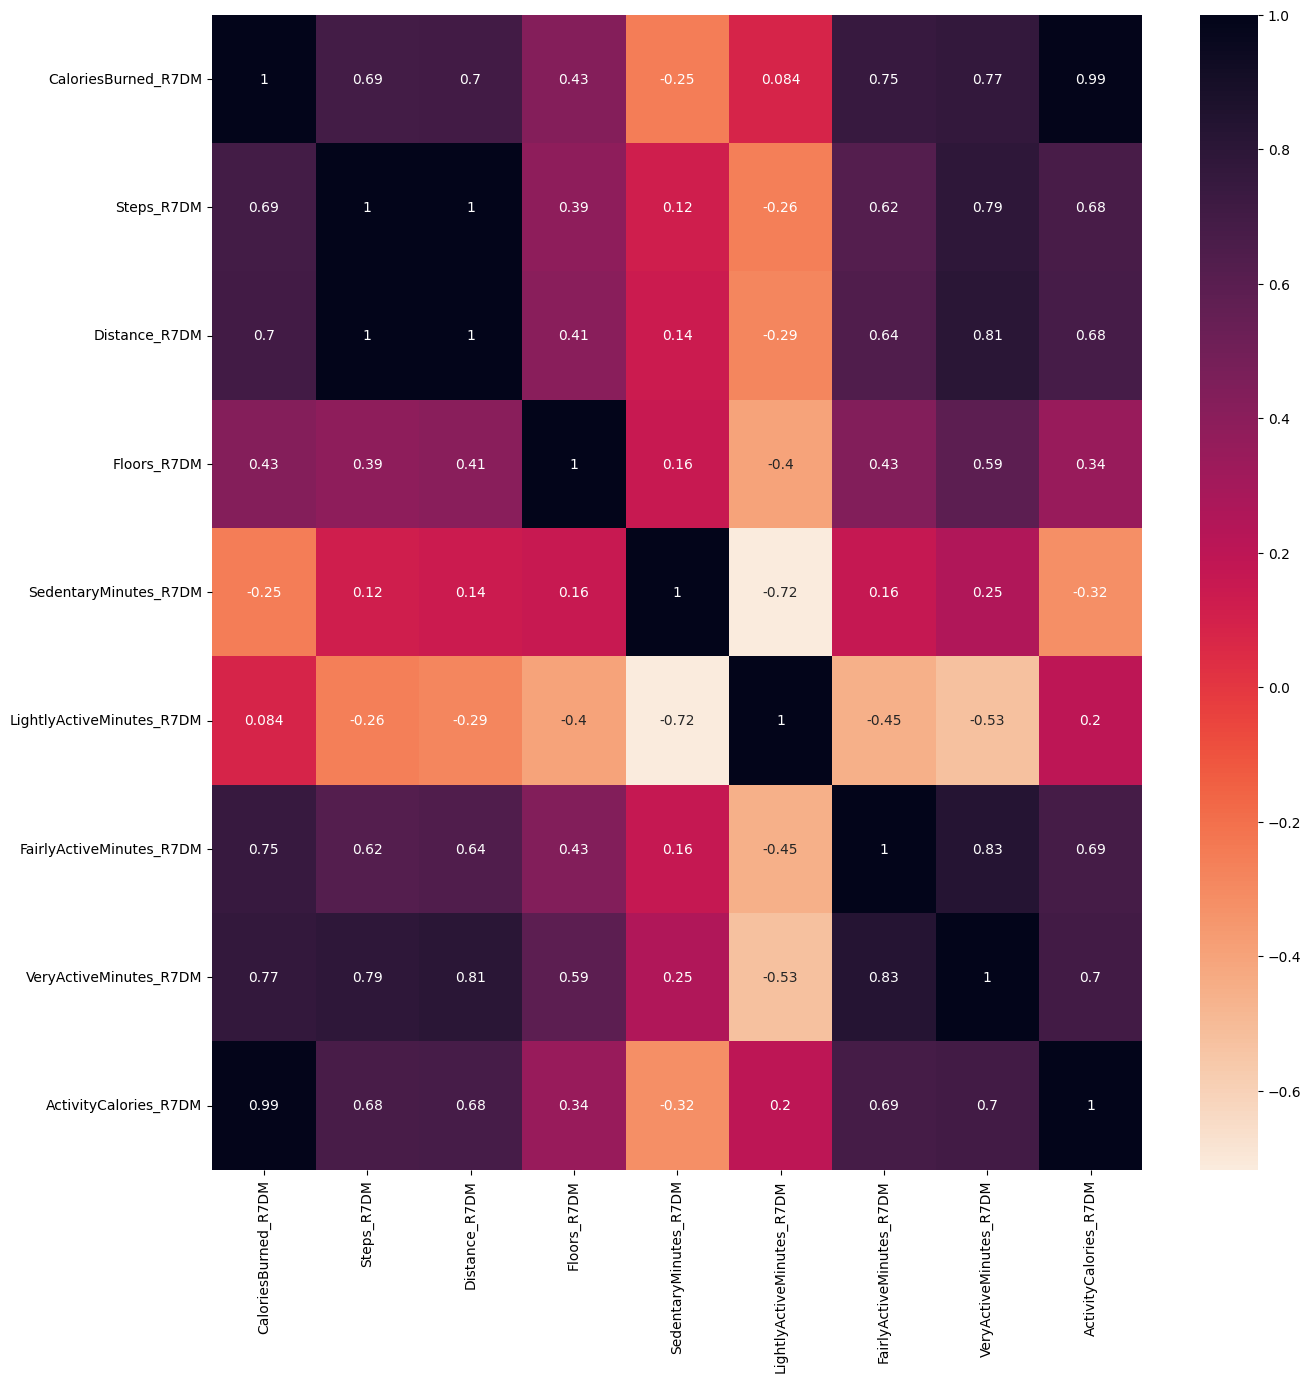

In [23]:
ax, fig = plt.subplots(figsize=(15, 15))
sns.heatmap(df_activity.iloc[:,-9:].corr(), annot=True, cmap="rocket_r")
x = 'Activity_Heatmap'
plt.savefig(f'./../visuals/{x}.png');

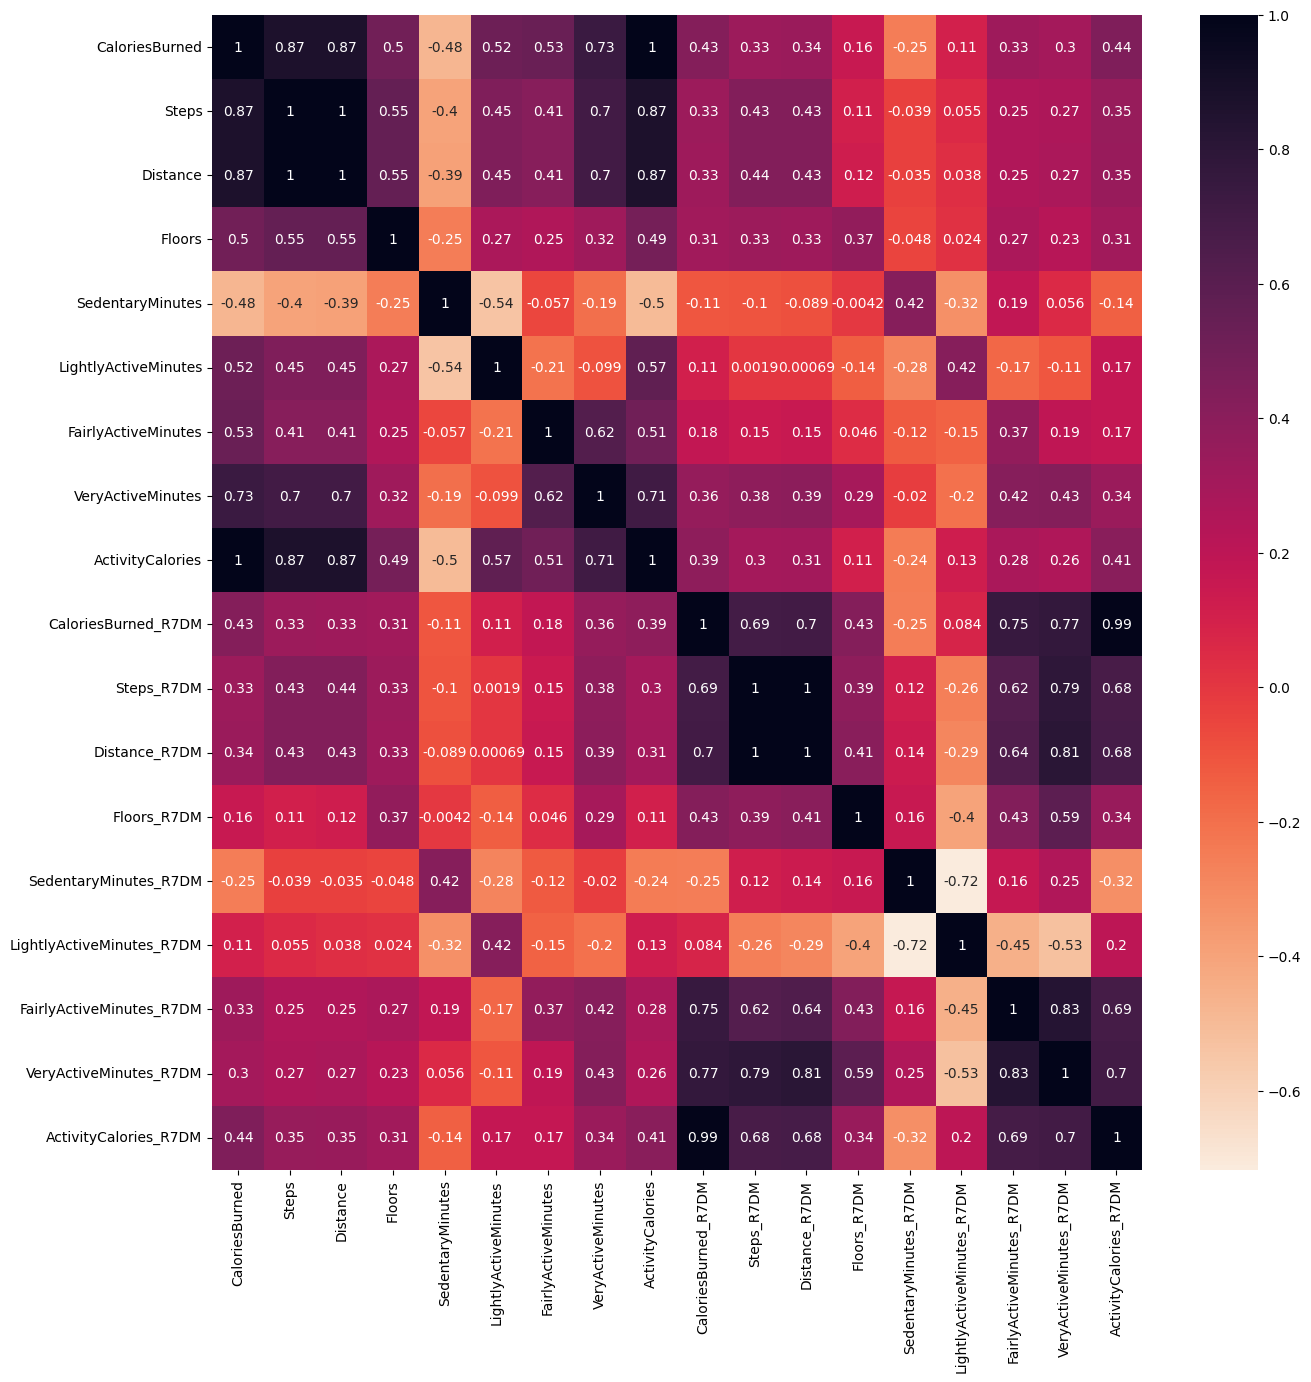

In [24]:
ax, fig = plt.subplots(figsize=(15, 15))
sns.heatmap(df_activity.corr(), annot=True, cmap="rocket_r")
x = 'Activity_Heatmap'
plt.savefig(f'./../visuals/{x}.png');

### Sleep Data

In [25]:
# Read in fitbit data 
path = '../data/'
dfs = [get_df(path + file, 'Sleep') for file in fitbit]
df_sleep = pd.concat(dfs).reset_index(drop=True).sort_values('Start Time').reset_index(drop=True)

In [26]:
start = df_sleep['Start Time']

In [27]:
df_sleep.head()

,Start Time,End Time,Minutes Asleep,Minutes Awake,Number of Awakenings,Time in Bed,Minutes REM Sleep,Minutes Light Sleep,Minutes Deep Sleep
0,2022-09-30 11:11PM,2022-10-01 7:32AM,447,54,33,501,80.0,277.0,90.0
1,2022-10-01 10:33PM,2022-10-02 7:21AM,437,91,32,528,84.0,297.0,56.0
2,2022-10-02 10:45PM,2022-10-03 6:52AM,426,61,28,487,104.0,264.0,58.0
3,2022-10-03 11:09PM,2022-10-04 6:35AM,382,64,28,446,53.0,247.0,82.0
4,2022-10-05 10:26PM,2022-10-06 7:07AM,428,93,25,521,90.0,236.0,102.0


In [28]:
df_sleep.tail()

,Start Time,End Time,Minutes Asleep,Minutes Awake,Number of Awakenings,Time in Bed,Minutes REM Sleep,Minutes Light Sleep,Minutes Deep Sleep
44,2022-11-21 11:34PM,2022-11-22 7:28AM,422,52,33,474,109.0,203.0,110.0
45,2022-11-21 1:23AM,2022-11-21 7:06AM,304,39,23,343,84.0,148.0,72.0
46,2022-11-22 11:50PM,2022-11-23 7:13AM,386,57,32,443,74.0,224.0,88.0
47,2022-11-23 11:53PM,2022-11-24 7:26AM,404,49,35,453,114.0,212.0,78.0
48,2022-11-24 11:24PM,2022-11-25 7:16AM,414,58,33,472,65.0,263.0,86.0


In [29]:
df_sleep.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49 entries, 0 to 48
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Start Time            49 non-null     object 
 1   End Time              49 non-null     object 
 2   Minutes Asleep        49 non-null     int64  
 3   Minutes Awake         49 non-null     int64  
 4   Number of Awakenings  49 non-null     int64  
 5   Time in Bed           49 non-null     int64  
 6   Minutes REM Sleep     47 non-null     float64
 7   Minutes Light Sleep   47 non-null     float64
 8   Minutes Deep Sleep    47 non-null     float64
dtypes: float64(3), int64(4), object(2)
memory usage: 3.6+ KB


#### Steps to take
- Rename all columns to match PEP8 style
- Convert Start and End Time to int64
- Create a date column to indicate the night of sleep
- Check for nights with multiple nights of sleep to remove invalid records

In [30]:
# Renaming all columns and adding an FB prefix for "FitBit"
df_sleep.columns = ['Onset', 'Offset', 'TST', 'WASO',
       'NOA', 'TIB', 'REMSD',
       'LSD', 'DSD']

# Convert Time columns to datetime format
for column in ['Onset', 'Offset']: df_sleep[column] = pd.to_datetime(df_sleep[column])

# We consider a sleep record for a particular day as the night before
# The sleep record for 2/1/22 will have a sleep record onset between 1/1/22 12:00 and 2/1/22 12:00
# This is relevant for predicting mood based on sleep the previous night(s) before.
# There is no point predicting mood using sleep data that is not yet available.
df_sleep['Date'] = pd.to_datetime((df_sleep.Onset + pd.Timedelta(12, 'h')).dt.date, format='%Y-%m-%d')

# Creating a numeric Bed and Wake Time that will enable easy analysis
df_sleep['Onset'] = df_sleep.Onset.dt.hour + (df_sleep.Onset.dt.minute / 60)
df_sleep['Offset'] = df_sleep.Offset.dt.hour + (df_sleep.Offset.dt.minute / 60)

# We will alter Onset so Onsets after midnight are considered later than Onsets before midnight
# eg. 00:00 is later than 23:00, this corresponds with how we perceive the flow of time at night
def add_hours(x):
    return x if x > 12 else x + 24

df_sleep.Onset  = df_sleep.Onset.apply(add_hours)
df_sleep.sort_values(['Date', 'Onset'], inplace=True)
df_sleep.reset_index(inplace=True, drop=True)

##### Visual Inspection

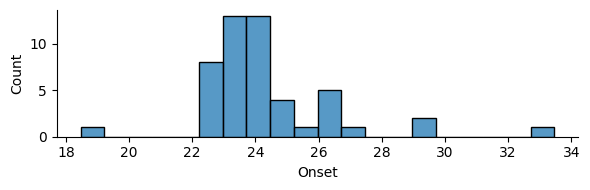

In [31]:
x = 'Onset'
sns.displot(data=df_sleep, x=x, aspect=3, height=2)
plt.savefig(f'./../visuals/FB_{x}.png');

In [32]:
# Inspecting the 3 records that have strange times
# Place a filter of before 20 hours or after 28 hours
dates = df_sleep.loc[(20 > df_sleep.Onset) | (df_sleep.Onset > 28), 'Date']
df_sleep.loc[df_sleep.Date.isin(dates)]

,Onset,Offset,TST,WASO,NOA,TIB,REMSD,LSD,DSD,Date
12,24.016667,3.700000,187,34,12,221,17.0,110.0,60.0,2022-10-21
13,29.116667,8.400000,165,32,12,197,33.0,105.0,27.0,2022-10-21
27,18.466667,20.650000,103,22,0,131,NaN,NaN,NaN,2022-11-05
28,23.433333,7.283333,412,59,31,471,80.0,260.0,72.0,2022-11-05
29,26.000000,7.933333,295,61,24,356,43.0,180.0,72.0,2022-11-06
30,33.466667,10.650000,65,6,1,71,NaN,NaN,NaN,2022-11-06
39,23.550000,3.483333,194,42,13,236,18.0,114.0,62.0,2022-11-17
40,29.216667,8.283333,159,24,12,183,4.0,117.0,38.0,2022-11-17


Here we have 4 instances where the fitbit watch created 2 records rather than 1 for the records on 2022-11-06 and 2022-11-05, we will only take the larger record as the additional records are False. On 2022-11-05, I was out with my watch in my pocket and I remember seeing that my watch had thought I was sleeping. For 2022-11-06, I would not have slept in until 10.39.
For the remaining records on 2022-10-21 and 2022-11-17, I will combine these. 
For 2022-10-21, I will use the 00:01 as Onset and 08:24 as Offset and add the difference between the first Offset (03:42) and and second Onset (05:07).
For 2022-11-17, I will use the 23:33 as Onset and 08:17 as Offset and add the difference between the first Offset (03:29) and and second Onset (05:13).

In [33]:
def merge(df_sleep, cond1, cond2):
    # Calculating time difference between 2 records
    time_diff = ((float(df_sleep.loc[cond2, 'Onset']) - 24) - float(df_sleep.loc[cond1, 'Offset'])) * 60

    # Setting the sleep onset to the earlier sleep onset
    df_sleep.loc[cond2, 'Onset'] = float(df_sleep.loc[cond1,'Onset'])

    # Finding indexes for records
    i = df_sleep.index[cond1][0]
    j = df_sleep.index[cond2][0]

    # Adding numeric columns together index = 2:9
    df_sleep.iloc[j, 2:9] += df_sleep.iloc[i, 2:9]

    # Add time_diff to WASO
    df_sleep.loc[cond2, 'WASO'] += time_diff
    df_sleep.loc[cond2, 'TIB'] += time_diff
    
    return df_sleep


In [34]:
# Creating a condition to filter the two datetimes
cond1 = (df_sleep.Date == '2022-10-21') & (df_sleep.Offset == 3.7)
cond2 = (df_sleep.Date == '2022-10-21') & (df_sleep.Offset == 8.4)

# Creating a condition to filter the two datetimes
cond3 = (df_sleep.Date == '2022-11-17') & (df_sleep.TST == 194)
cond4 = (df_sleep.Date == '2022-11-17') & (df_sleep.TST == 159)

# Merge the two double file instances
df_sleep = merge(df_sleep, cond1, cond2)
df_sleep = merge(df_sleep, cond3, cond4)

# Removing other files
cond5 = (20 > df_sleep.Onset) | (df_sleep.Onset > 28)
df_sleep = df_sleep.loc[~cond5]

In [35]:
df_sleep.loc[cond2 | cond4]

,Onset,Offset,TST,WASO,NOA,TIB,REMSD,LSD,DSD,Date
13,24.016667,8.400000,352,151.0,24,503.0,50.0,215.0,87.0,2022-10-21
40,23.550000,8.283333,353,170.0,25,523.0,22.0,231.0,100.0,2022-11-17


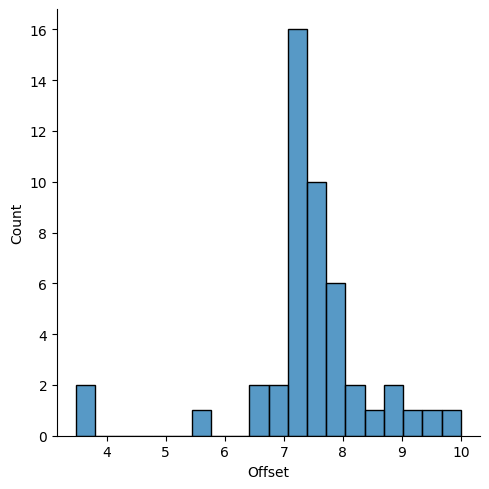

In [36]:
x = 'Offset'
sns.displot(data=df_sleep, x=x)
plt.savefig(f'./../visuals/FB_{x}.png');

We can see below that the redundent records above have not been removed.
We can remove them with a simple filter

In [37]:
df_sleep.loc[df_sleep.Offset < 4]

,Onset,Offset,TST,WASO,NOA,TIB,REMSD,LSD,DSD,Date
12,24.016667,3.700000,187,34.0,12,221.0,17.0,110.0,60.0,2022-10-21
39,23.550000,3.483333,194,42.0,13,236.0,18.0,114.0,62.0,2022-11-17


In [38]:
df_sleep = df_sleep.loc[~(df_sleep.Offset < 4)]

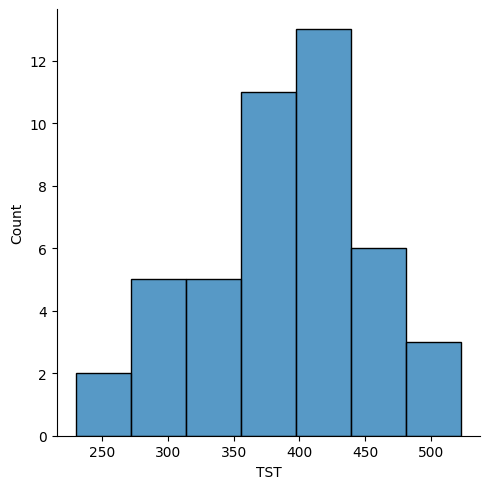

In [39]:
x = 'TST'
sns.displot(data=df_sleep, x=x)
plt.savefig(f'./../visuals/FB_{x}.png');

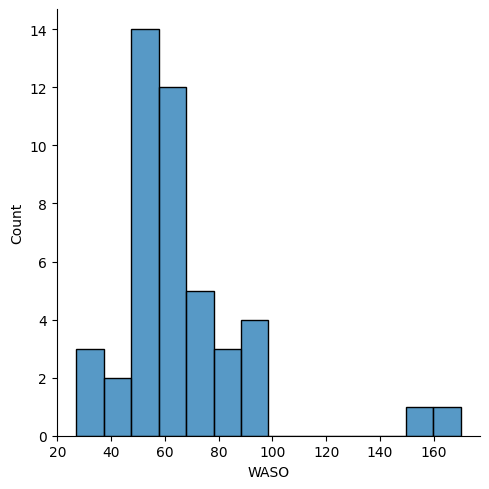

In [40]:
x = 'WASO'
sns.displot(data=df_sleep, x=x)
plt.savefig(f'./../visuals/FB_{x}.png');

There two extreme values. These are the sleep records I joined together. The record split on those nights because I woke up and was unable to get back to sleep for over an hour.

In [41]:
# Sleep Record with large WASO
df_sleep.loc[df_sleep.WASO > 120]

,Onset,Offset,TST,WASO,NOA,TIB,REMSD,LSD,DSD,Date
13,24.016667,8.400000,352,151.0,24,503.0,50.0,215.0,87.0,2022-10-21
40,23.550000,8.283333,353,170.0,25,523.0,22.0,231.0,100.0,2022-11-17


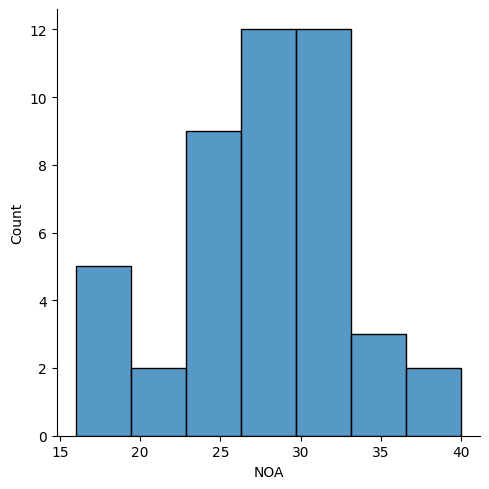

In [42]:
x = 'NOA'
sns.displot(data=df_sleep, x=x)
plt.savefig(f'./../visuals/FB_{x}.png');

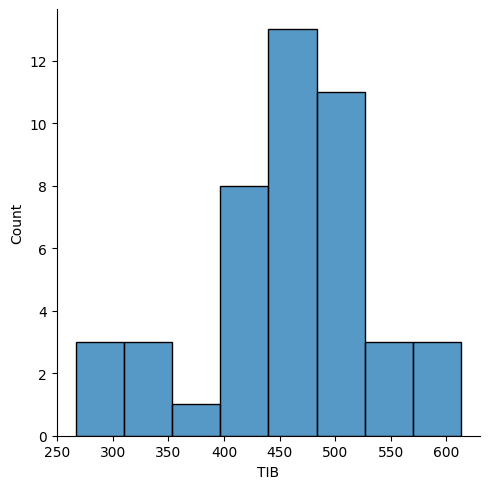

In [43]:
x = 'TIB'
sns.displot(data=df_sleep, x=x)
plt.savefig(f'./../visuals/FB_{x}.png');

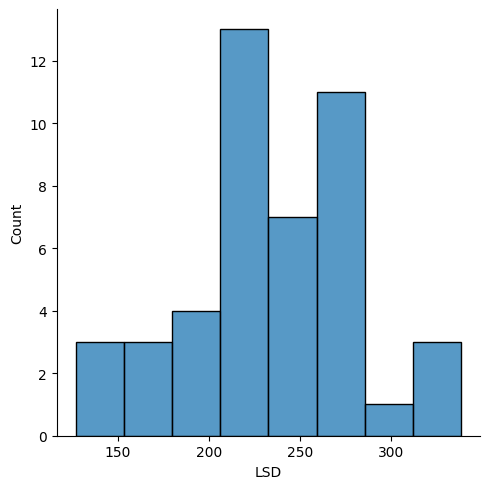

In [44]:
x = 'LSD'
sns.displot(data=df_sleep, x=x)
plt.savefig(f'./../visuals/FB_{x}.png');

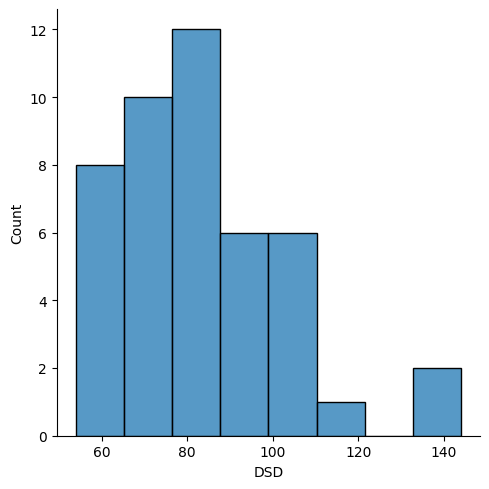

In [45]:
x = 'DSD'
sns.displot(data=df_sleep, x=x)
plt.savefig(f'./../visuals/FB_{x}.png');

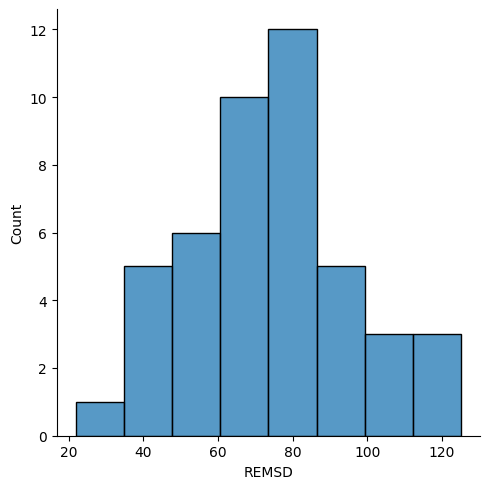

In [46]:
x = 'REMSD'
sns.displot(data=df_sleep, x=x)
plt.savefig(f'./../visuals/FB_{x}.png');

#### Steps Completed
- ~Rename all columns to match PEP8 style~
- ~Convert Start and End Time to int64~
- ~Create a date column to indicate the night of sleep~
- ~Check for nights with multiple nights of sleep to remove invalid records~

### SleepScore Data
I have received all my data from SleepScore however, I will only be working with data that corresponds with the fitbit. Therefore, I will filter the data before October 1st and after November 24th.

In [47]:
# Read in sleepscore data
path_sleepscore = '../data/sleepscore.csv'
df_sleepscore = pd.read_csv(path_sleepscore)

There are many variables in the SleepScore Data. Many are not useful for this analysis and I will remove them.

#### Steps to take
- Separate sleep and logging data
- Filter out columns
- Rename columns
- Correct Data Types
- Create Date column
- Filter data between October 1st and November 11th
- Remove Dodgy Sleep Records by sleep variables
- Visualise each column

I am splitting the sleepscore data into two dataframes, one with sleep data only and one with non-sleep related data.

In [48]:
# Create Date column
df_sleepscore['Date'] = pd.to_datetime((pd.to_datetime(df_sleepscore.LocalStartTime) + pd.Timedelta(12, 'h')).dt.date, format='%Y-%m-%d')

# Filter out rows between October 1st and November 11th
df_sleepscore = df_sleepscore.loc[df_sleepscore.Date >= '2022-10-01'].sort_values('Date').reset_index(drop=True)

In [49]:
# Creating a logging dataframe (separate from sleep data)
logging_columns = [
    'Date', 'CaffeineCups', 'AlcoholDrinks', 'Stress', 'Sleepiness', 'Mood',
    'GeoLatitude','GeoLongitude'
]
df_ss_logging = df_sleepscore[logging_columns]

new_logging_columns = [
    'Date', 'CaffeineCups', 'AlcoholDrinks', 'Stress', 'Sleepiness', 'Mood',
    'GeoLatitude','GeoLongitude'
]

# Filter out columns
sleep_columns = [
    'Date', 'BedTime', 'TimeToSleep', 'TotalSleepTime', 'WASO', 'wakeTime', 'TimeInBed',
    'NumberOfInterruptions', 'LightSleepDuration', 'DeepSleepDuration', 'REMSleepDuration', 'AverageRespirationRate',
    'SleepScore', 'MindScore', 'BodyScore',
    'SleepEfficiency', 'SleepMaintenanceIndex', 'ArousalIndex', 'REMPercentage', 'SWSPercentage'
]
df_sleepscore = df_sleepscore[sleep_columns]


# Shortening variable names for easier comprehenshion
new_sleep_columns = [
    'Date', 'Bedtime', 'SOL', 'TST', 'WASO', 'Waketime', 'TIB', 
    'NOA', 'LSD', 'DSD', 'REMSD', 'ARR',
    'SS', 'MS', 'BS',    
    'SE', 'SMI', 'AI','REMP', 'SWSP'
]
df_sleepscore.columns = new_sleep_columns

# Create a dictionary to for easy checking of shorted variabled names
dict_columns = dict(zip(new_sleep_columns + new_logging_columns, sleep_columns + logging_columns))

In [50]:
df_ss_logging.head()

,Date,CaffeineCups,AlcoholDrinks,Stress,Sleepiness,Mood,GeoLatitude,GeoLongitude
0,2022-10-01,0,0,4,4,NaN,53.780268,-7.469254
1,2022-10-02,0,0,6,11,NaN,53.780260,-7.469239
2,2022-10-03,0,0,13,14,NaN,53.780263,-7.469287
3,2022-10-04,0,0,6,8,NaN,53.383453,-6.257561
4,2022-10-05,0,1,4,11,NaN,53.383464,-6.257524


In [51]:
df_sleepscore.head()

,Date,Bedtime,SOL,TST,WASO,Waketime,TIB,NOA,LSD,DSD,REMSD,ARR,SS,MS,BS,SE,SMI,AI,REMP,SWSP
0,2022-10-01,23.062778,21,455,32,7.529444,508,6,214,152,89,13.86,92,87,92,89.57,93,0.79,19.56,33.41
1,2022-10-02,22.387222,19,461,50,7.312222,535,9,252,112,96,13.82,92,94,83,86.17,89,1.17,20.82,24.30
2,2022-10-03,22.571667,18,447,31,6.980000,504,6,246,95,106,14.11,91,91,79,88.69,92,0.81,23.71,21.25
3,2022-10-04,22.734722,51,411,22,6.884722,489,3,253,126,31,14.15,79,53,87,84.05,94,0.44,7.54,30.66
4,2022-10-05,24.507500,8,378,18,7.265833,404,6,185,118,74,14.85,85,83,85,93.56,95,0.95,19.58,31.22


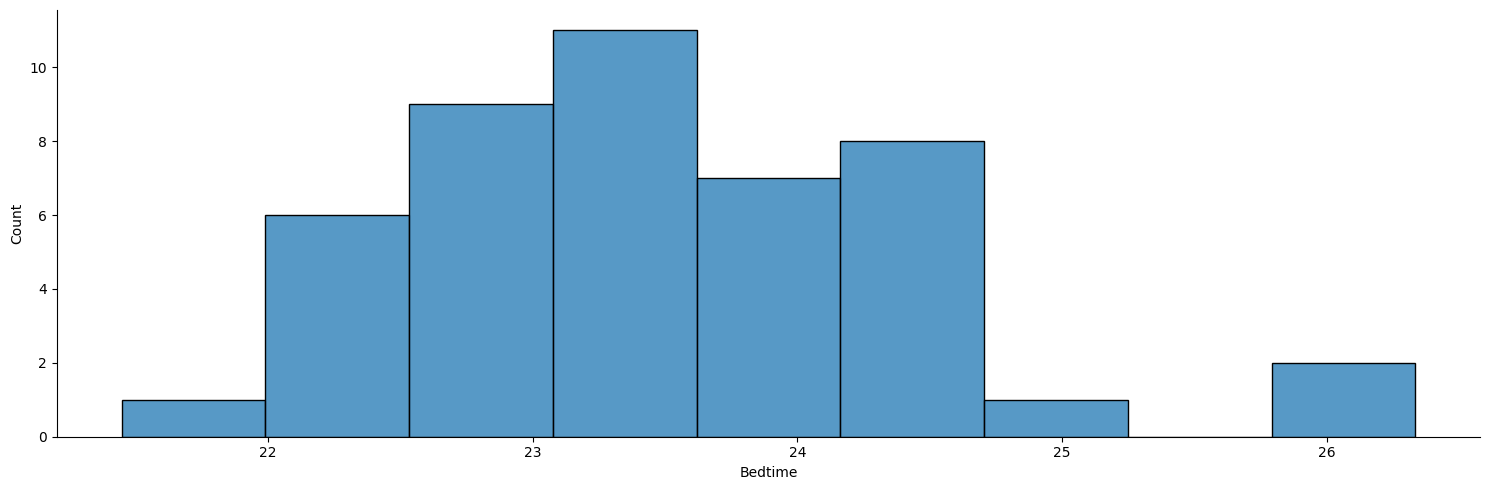

In [52]:
x = 'Bedtime'
sns.displot(data=df_sleepscore, x=x, aspect=3)
plt.savefig(f'./../visuals/SS_{x}.png');

There are two records that have later bedtimes but these are just times I couldn't get to sleep until later.

In [53]:
df_sleepscore.loc[df_sleepscore.Bedtime > 25.5]

,Date,Bedtime,SOL,TST,WASO,Waketime,TIB,NOA,LSD,DSD,REMSD,ARR,SS,MS,BS,SE,SMI,AI,REMP,SWSP
21,2022-10-31,26.335000,8,258,43,7.576667,314,5,90,111,56,13.78,59,66,83,82.17,84,1.16,21.71,43.02
32,2022-11-12,26.163333,7,405,8,9.188333,421,1,147,132,126,13.70,89,94,88,96.20,98,0.15,31.11,32.59


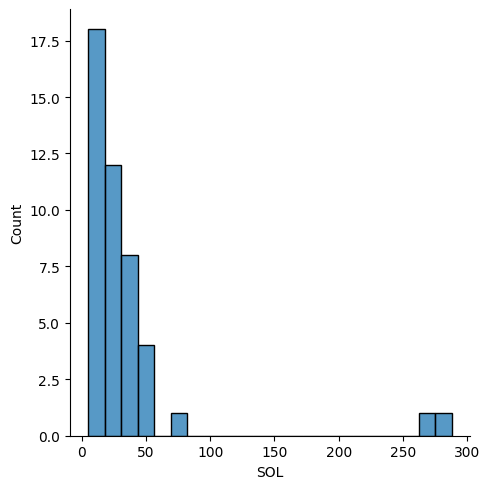

In [54]:
x = 'SOL'
sns.displot(data=df_sleepscore, x=x)
plt.savefig(f'./../visuals/SS_{x}.png');

There are two records with large Sleep Onset Latency, I am unsure whether these are false records or not. I will explore this with further analysis

In [55]:
df_sleepscore.loc[df_sleepscore.SOL > 250]

,Date,Bedtime,SOL,TST,WASO,Waketime,TIB,NOA,LSD,DSD,REMSD,ARR,SS,MS,BS,SE,SMI,AI,REMP,SWSP
11,2022-10-15,23.067500,271,169,15,6.717500,458,2,116,24,29,13.81,39,47,46,36.9,90,0.71,17.16,14.20
37,2022-11-18,22.326667,288,237,3,7.151667,529,1,162,11,64,14.05,51,69,34,44.8,98,0.25,27.00,4.64


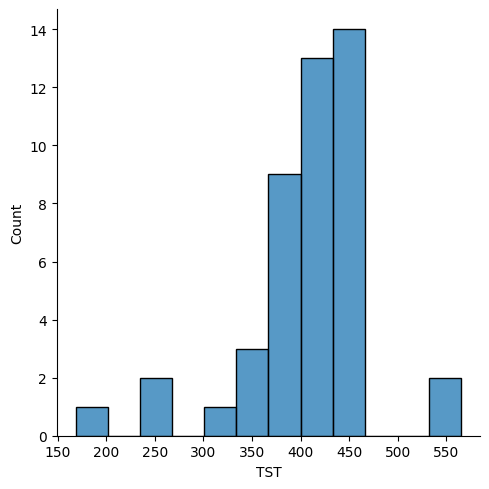

In [56]:
x = 'TST'
sns.displot(data=df_sleepscore, x=x)
plt.savefig(f'./../visuals/SS_{x}.png');

Let's inspect the very short records and determine whether they are legitimate or if it is an invalid record.
I also looked at the two very long records but they were just when I sleeped in on a Sunday

In [57]:
df_sleepscore.loc[((df_sleepscore.TST < 300) | (df_sleepscore.TST > 500))]

,Date,Bedtime,SOL,TST,WASO,Waketime,TIB,NOA,LSD,DSD,REMSD,ARR,SS,MS,BS,SE,SMI,AI,REMP,SWSP
11,2022-10-15,23.067500,271,169,15,6.717500,458,2,116,24,29,13.81,39,47,46,36.90,90,0.71,17.16,14.20
20,2022-10-30,21.446111,18,534,27,7.129444,580,4,305,118,111,14.07,94,92,85,92.07,95,0.45,20.79,22.10
21,2022-10-31,26.335000,8,258,43,7.576667,314,5,90,111,56,13.78,59,66,83,82.17,84,1.16,21.71,43.02
37,2022-11-18,22.326667,288,237,3,7.151667,529,1,162,11,64,14.05,51,69,34,44.80,98,0.25,27.00,4.64
39,2022-11-20,23.522778,19,565,20,9.631111,606,4,230,201,133,14.07,96,99,98,93.23,96,0.42,23.54,35.58


After inspecting the 15/10 record from my phone I can see there were multiple hours where it was paused. I was playing a podcast at the time and this paused the sleep tracking resulting in a poor record. This will now be removed. If you look at the other very low record. 31/10 was recorded on the night before Halloween, I think we all know why I got bad sleep on that night! I was out with my friends. We will drop the 15/10 record but leave the halloween record.
18/11 is also a record with poor signal so that will be removed.

In [58]:
i = df_sleepscore.index[df_sleepscore.Date.isin(['2022-10-15', '2022-11-18'])]
df_sleepscore.drop(i, inplace=True)

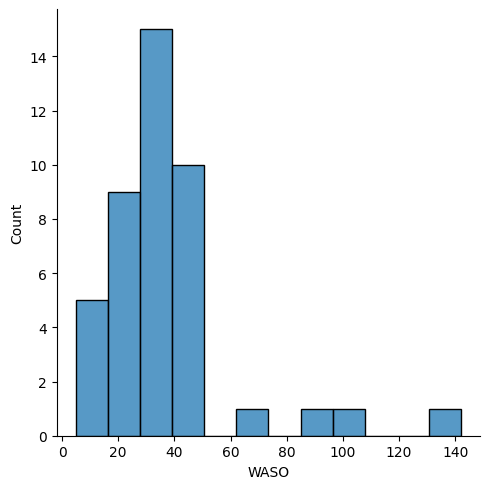

In [59]:
x = 'WASO'
sns.displot(data=df_sleepscore, x=x)
plt.savefig(f'./../visuals/SS_{x}.png');

Looking at the 4 records below we can see the first three are quite normal however, after checking 2022-11-17, I can see a lot of signal issues on my phone. This will be removed.

In [60]:
df_sleepscore.loc[df_sleepscore.WASO > 60]

,Date,Bedtime,SOL,TST,WASO,Waketime,TIB,NOA,LSD,DSD,REMSD,ARR,SS,MS,BS,SE,SMI,AI,REMP,SWSP
5,2022-10-06,22.279722,15,423,91,7.104722,522,4,220,116,87,13.95,81,82,84,81.03,83,0.57,20.57,27.42
9,2022-10-13,22.178611,49,425,69,7.311944,519,9,261,115,49,13.42,82,68,84,81.89,90,1.27,11.53,27.06
17,2022-10-21,23.935000,8,390,104,8.376667,506,6,211,132,47,14.32,74,62,88,77.08,78,0.92,12.05,33.85
36,2022-11-17,23.269722,32,302,142,7.244722,476,6,186,89,27,14.19,54,50,77,63.45,68,1.19,8.94,29.47


In [61]:
df_sleepscore = df_sleepscore.loc[~(df_sleepscore.Date == '2022-11-17')]

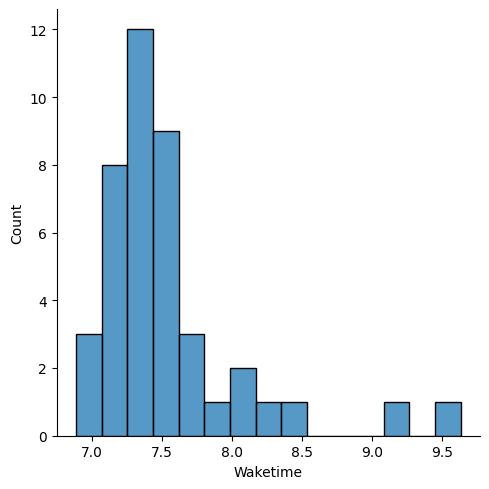

In [62]:
x = 'Waketime'
sns.displot(data=df_sleepscore, x=x)
plt.savefig(f'./../visuals/SS_{x}.png');

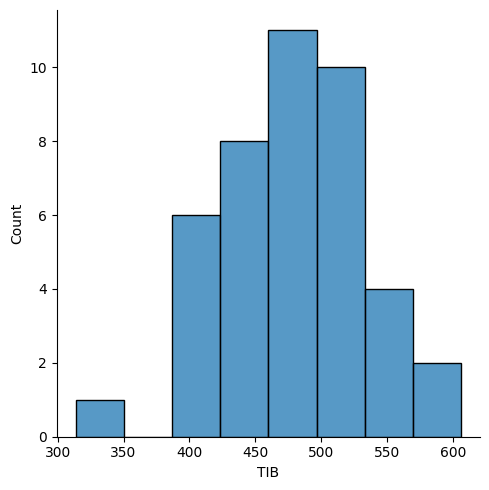

In [63]:
x = 'TIB'
sns.displot(data=df_sleepscore, x=x)
plt.savefig(f'./../visuals/SS_{x}.png');

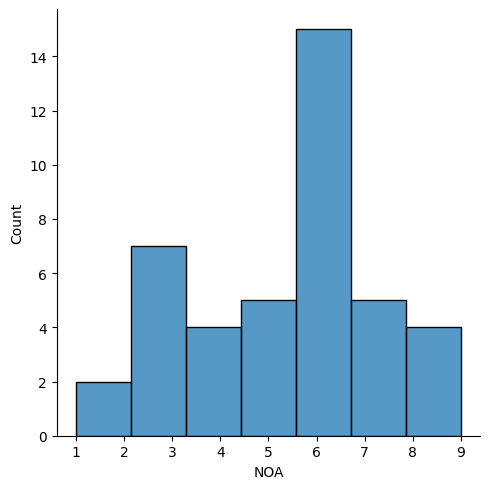

In [64]:
x = 'NOA'
sns.displot(data=df_sleepscore, x=x)
plt.savefig(f'./../visuals/SS_{x}.png');

Usually it is unusual for someone only to have one or two awakenings. I will check this record. AFter checking below we can see these records are fine. Interesting, how high the SMI is...99%!

In [65]:
df_sleepscore.loc[df_sleepscore.NOA < 3]

,Date,Bedtime,SOL,TST,WASO,Waketime,TIB,NOA,LSD,DSD,REMSD,ARR,SS,MS,BS,SE,SMI,AI,REMP,SWSP
32,2022-11-12,26.163333,7,405,8,9.188333,421,1,147,132,126,13.70,89,94,88,96.20,98,0.15,31.11,32.59
38,2022-11-19,24.670000,55,349,5,7.511667,409,1,163,113,72,15.19,77,86,84,85.33,99,0.17,20.63,32.38


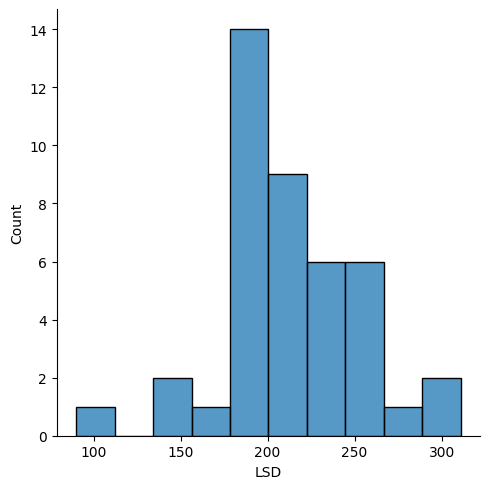

In [66]:
x = 'LSD'
sns.displot(data=df_sleepscore, x=x)
plt.savefig(f'./../visuals/SS_{x}.png');

Once again, we come across the halloween night sleep record. Very low light sleep

In [67]:
df_sleepscore.loc[df_sleepscore.LSD < 125]

,Date,Bedtime,SOL,TST,WASO,Waketime,TIB,NOA,LSD,DSD,REMSD,ARR,SS,MS,BS,SE,SMI,AI,REMP,SWSP
21,2022-10-31,26.335,8,258,43,7.576667,314,5,90,111,56,13.78,59,66,83,82.17,84,1.16,21.71,43.02


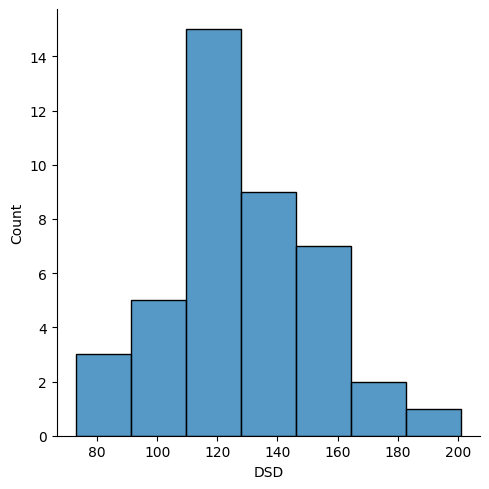

In [68]:
x = 'DSD'
sns.displot(data=df_sleepscore, x=x)
plt.savefig(f'./../visuals/SS_{x}.png');

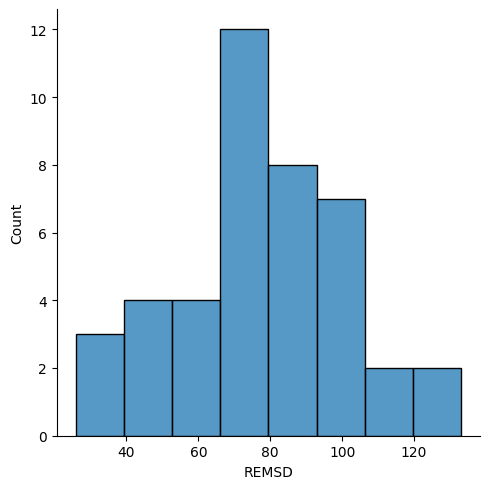

In [69]:
x = 'REMSD'
sns.displot(data=df_sleepscore, x=x)
plt.savefig(f'./../visuals/SS_{x}.png');

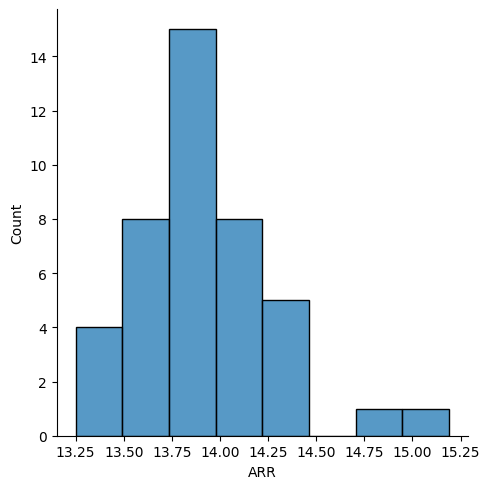

In [70]:
x = 'ARR'
sns.displot(data=df_sleepscore, x=x)
plt.savefig(f'./../visuals/SS_{x}.png');

Let's inspect the higher Average Respiration Rate value. Based on the table below, the sleep session appears valid and healthy.

In [71]:
df_sleepscore.loc[df_sleepscore.ARR > 14.5]

,Date,Bedtime,SOL,TST,WASO,Waketime,TIB,NOA,LSD,DSD,REMSD,ARR,SS,MS,BS,SE,SMI,AI,REMP,SWSP
4,2022-10-05,24.5075,8,378,18,7.265833,404,6,185,118,74,14.85,85,83,85,93.56,95,0.95,19.58,31.22
38,2022-11-19,24.6700,55,349,5,7.511667,409,1,163,113,72,15.19,77,86,84,85.33,99,0.17,20.63,32.38


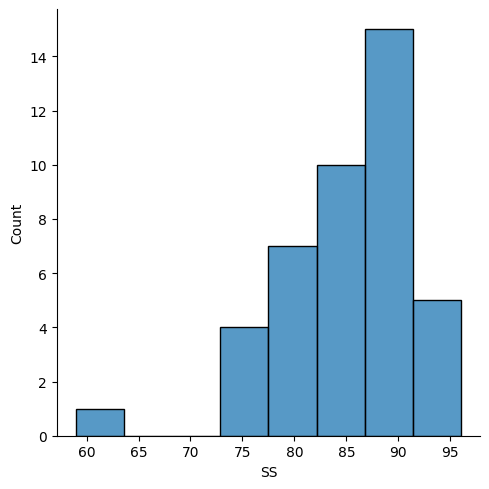

In [72]:
x = 'SS'
sns.displot(data=df_sleepscore, x=x)
plt.savefig(f'./../visuals/SS_{x}.png');

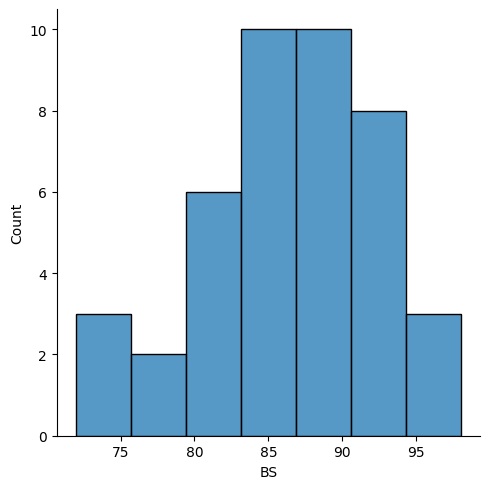

In [73]:
x = 'BS'
sns.displot(data=df_sleepscore, x=x)
plt.savefig(f'./../visuals/SS_{x}.png');

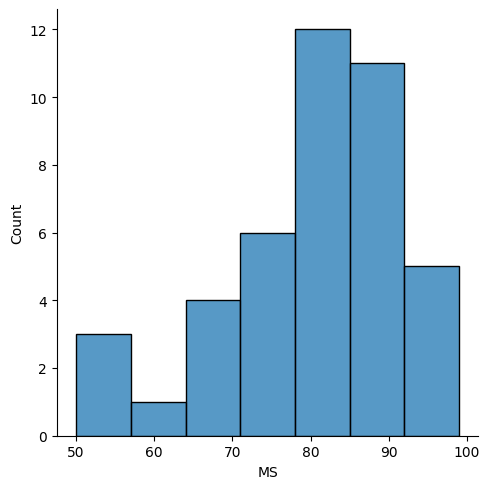

In [74]:
x = 'MS'
sns.displot(data=df_sleepscore, x=x)
plt.savefig(f'./../visuals/SS_{x}.png');

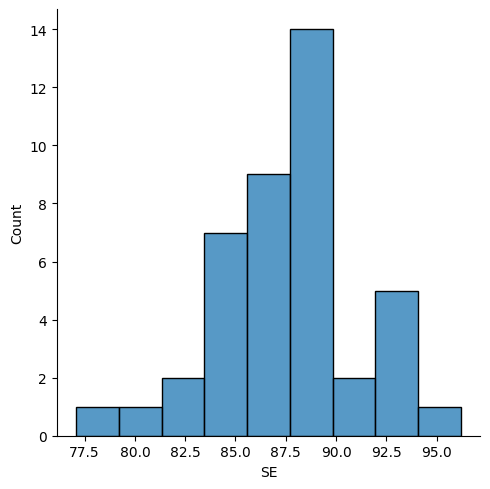

In [75]:
x = 'SE'
sns.displot(data=df_sleepscore, x=x)
plt.savefig(f'./../visuals/SS_{x}.png');

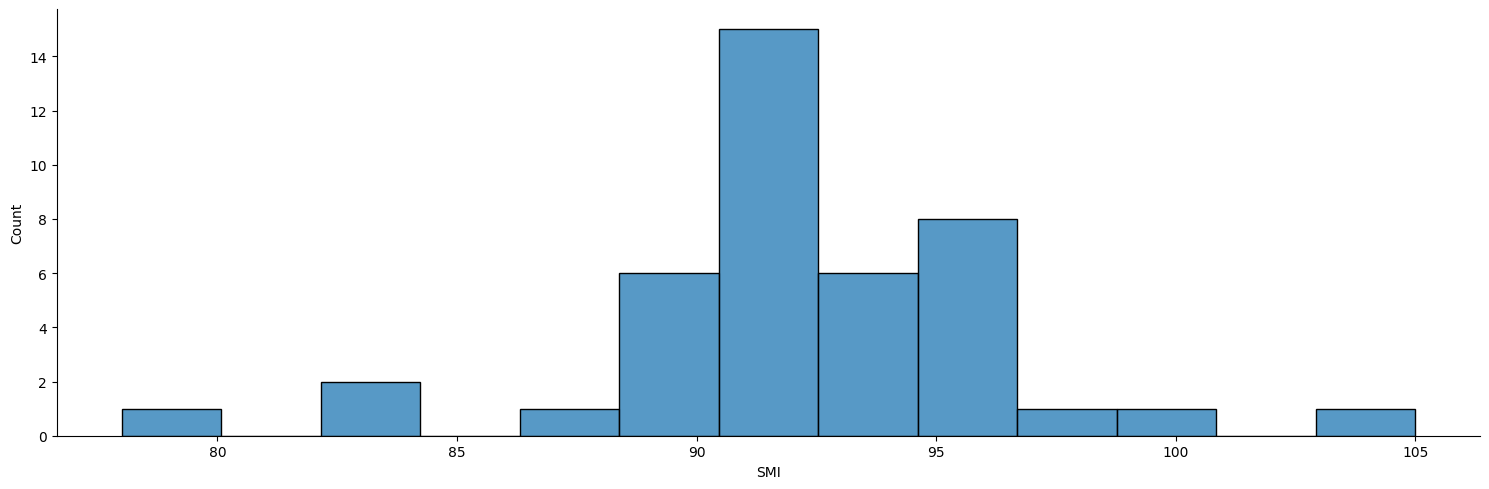

In [76]:
x = 'SMI'
sns.displot(data=df_sleepscore, x=x, aspect=3)
plt.savefig(f'./../visuals/SS_{x}.png');

The value of 105 is definitely an error. SMI is calculated as shown below TST / (TIB - SOL). This calculation does not factor in that TIB is dependent on signal quality while SOl is not therefore SOL + TST can be greater than TIB or TST > TIB - SOL. In this instance the time of no signal during SOL > WASO and therefore SMI > 100. We will fix this calculation later in Feature Engineering.

In [77]:
df_sleepscore.loc[df_sleepscore.SMI > 100]

,Date,Bedtime,SOL,TST,WASO,Waketime,TIB,NOA,LSD,DSD,REMSD,ARR,SS,MS,BS,SE,SMI,AI,REMP,SWSP
26,2022-11-06,24.673333,79,340,12,7.931667,404,3,179,79,82,14.15,75,90,74,84.16,105,0.53,24.12,23.24


In [78]:
cond = df_sleepscore.Date == '2022-11-06'
df_sleepscore.loc[cond].eval('TST / (TIB - SOL)')

26    1.046154
dtype: float64

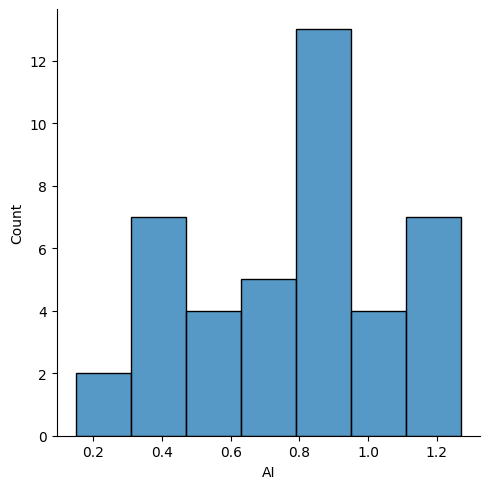

In [79]:
x = 'AI'
sns.displot(data=df_sleepscore, x=x)
plt.savefig(f'./../visuals/SS_{x}.png');

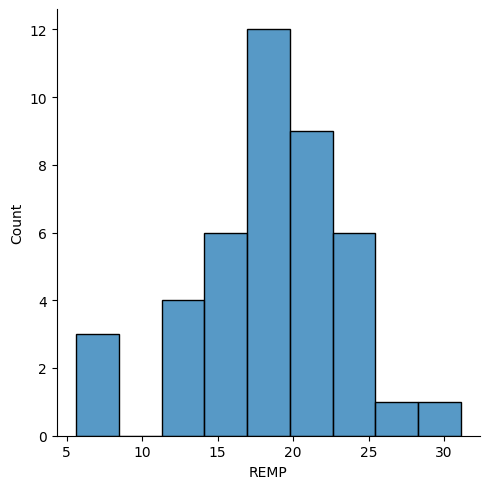

In [80]:
x = 'REMP'
sns.displot(data=df_sleepscore, x=x)
plt.savefig(f'./../visuals/SS_{x}.png');

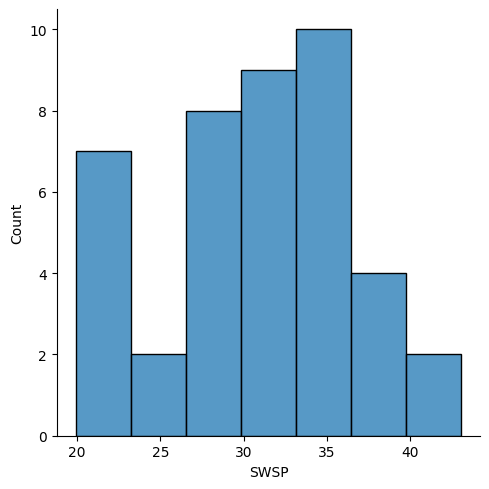

In [81]:
x = 'SWSP'
sns.displot(data=df_sleepscore, x=x)
plt.savefig(f'./../visuals/SS_{x}.png');

In [82]:
df_sleepscore.reset_index(drop=True, inplace=True)

#### Steps Completed
- ~Separate sleep and logging data~
- ~Filter out columns~
- ~Rename columns~
- ~Correct Data Types~
- ~Create Date column~
- ~Filter data between October 1st and November 11th~
- ~Remove Dodgy Sleep Records by sleep variables~
- ~Visualise each column~

### Fitbit and SleepScore Feature Engineering
There are several sleep metrics that are predictive of sleep quality we will use these to try and predict mood
- Sleep Onset - Bedtime + Sleep Onset Latency (SOL)
- Midpoint - Mean Sleep Onset and Offset
- SWS Percentage - Deep Sleep Duration / Total Sleep Time (TST) * 100
- REM Percentage - REM Sleep Duration / TST * 100
- Sleep Efficiency - TST / Time In Bed (TIB) * 100
- Total Sleep Period Duration (TSPD) = TST + WASO
- Sleep Maintainence Index - TST / TSDP (SleepScore only) * 100
- Arousal Index/Sleep Fragmentation Rate - Number of Awakenings / TST * 60
- Day of Week (Monday - Sunday)
- IsWeekend (Friday Night and Saturday Night)

#### SleepScore Only
This only involves calculating Sleep Onset and Offset

In [83]:
df_sleepscore['Onset'] = df_sleepscore.Bedtime + (df_sleepscore.SOL / 60)
df_sleepscore['Offset'] = df_sleepscore.Waketime

#### Fitbit Only
This involves calculating
- TSDP and comparing it with TIB
- SE depending on if TIB is different to TSDP
- Arousal Index
- SWS Percentage
- REM Percentage

The Fitbit Time In
I am unable to calculate Sleep Efficiency because Sleep Onset Latency is not available. 

In [84]:
df_sleep['TSDP'] = df_sleep.eval('TST + WASO')

In [85]:
# Calculate the difference between Time in Bed and Total Sleep Duration Period
df_sleep.eval('TIB - TSDP').value_counts()

0.0    45
dtype: int64

We can see that TSDP is the same as TIB and therefore, we cannot calculate SleepEfficiency. 

In [86]:
df_sleep['AI'] = df_sleep.eval('NOA / TST * 60')

In [87]:
df_sleep['SWSP'] = df_sleep.eval('DSD / TST * 100')
df_sleep['REMP'] = df_sleep.eval('REMSD / TST * 100')

#### Both SleepScore and Fitbit
- SMI
- Midpoint
- Day
- IsWeekend

For SleepScore we need to calculate the period between Sleep Onset and Offset

In [88]:
def tsdp(df):
    ''' This calculates total sleep duration period using onset and offset '''
    # if onset is after midnight, calculate difference between onset and offset
    if df.Onset > 24:
        df['TSDP'] = (df.Offset - (df.Onset - 24)) * 60
    # if after midnight add time before and after midnight
    else:
        df['TSDP'] = (df.Offset + (24 - df.Onset)) * 60
    return df

# Calculating Total Sleep Duration Period
df_sleep = df_sleep.apply(tsdp, axis=1)
df_sleepscore = df_sleepscore.apply(tsdp, axis=1)

# Calculating Sleep Maintenance Index
df_sleep['SMI'] = df_sleep.eval('TST / TSDP * 100')
df_sleepscore['SMI'] = df_sleepscore.eval('TST / TSDP * 100')

# Calculating Mean Wake Duration = WASO / Number Of Awakenings
df_sleep['MWD'] = df_sleep.eval('WASO / NOA')
df_sleepscore['MWD'] = df_sleepscore.eval('WASO / NOA')

In [89]:
def midpoint(df):
    ''' This calculates the sleep midpoint between onset and offset'''
    # if it's after midnight get the mean of onset and offset
    if df.Onset > 24:
        df['Midpoint'] = ((df.Onset - 24) + df.Offset) / 2
    # if it's before midnight calculate hours before and after midnight for onset and offset and divide by 2
    else:
        df['Midpoint'] = ((24 - df.Onset) + df.Offset) / 2
    
    return df

# Calculating the midpoint
df_sleep = df_sleep.apply(midpoint, axis=1)
df_sleepscore = df_sleepscore.apply(midpoint, axis=1)

In [90]:
# Let's calculate the mean wake duration = WASO / number of awakenings
df_sleepscore['MWD'] = df_sleepscore.eval('WASO / NOA')
df_sleep['MWD'] = df_sleep.eval('WASO / NOA')

In [91]:
# Creating full date indexes
df_sleep = df_sleep.merge(
    pd.date_range(start=df_sleep.Date.min(),
                  end=df_sleep.Date.max()
                 ).to_series().reset_index(drop=True).rename('Date'), on='Date', how='outer').sort_values('Date')
df_sleepscore = df_sleepscore.merge(
    pd.date_range(start=df_sleepscore.Date.min(),
                  end=df_sleepscore.Date.max()
                 ).to_series().reset_index(drop=True).rename('Date'), on='Date', how='outer').sort_values('Date')

In [92]:
for df in [df_sleep, df_sleepscore]:
    df['Day'] = pd.Categorical(df.Date.dt.day_name(),['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], ordered=True)
    df['IsWeekend'] = df.Day.isin(['Saturday', 'Sunday']).astype('int')

There is one more feature I have to calculate which is Sleep Regularity. This requires me to create rows for all missing dates and perform a rolling standard deviation of the Midpoint.

In [93]:
df_sleep['SR'] = df_sleep.Midpoint.rolling(7, 3).std()
df_sleepscore['SR'] = df_sleepscore.Midpoint.rolling(7, 3).std()

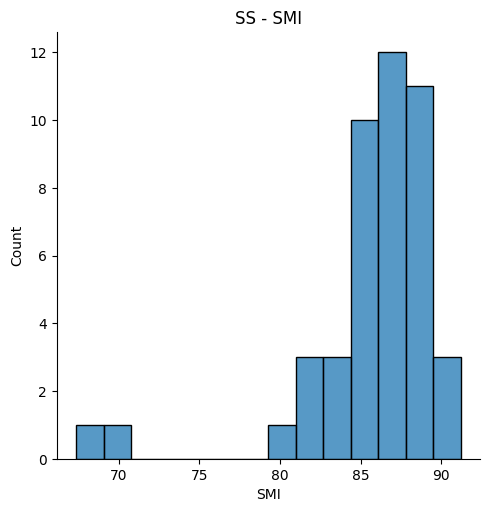

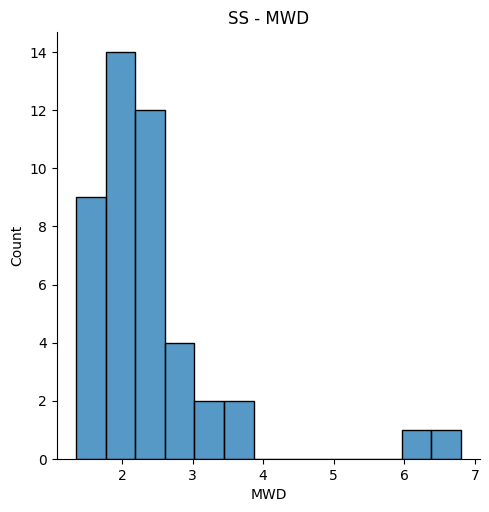

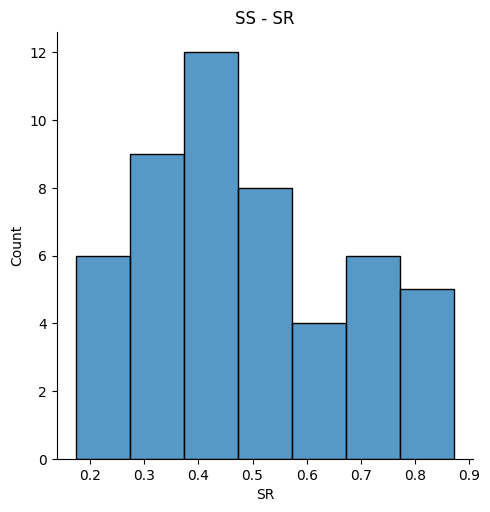

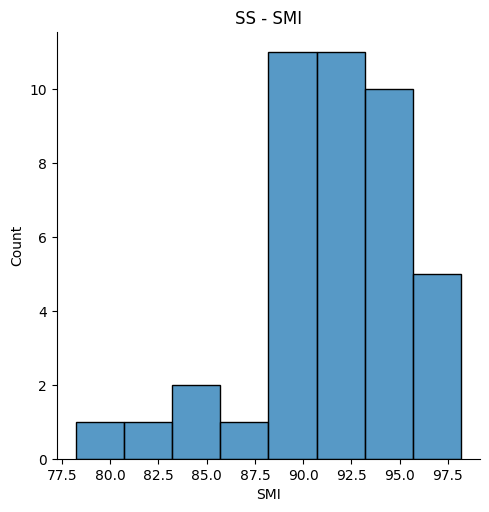

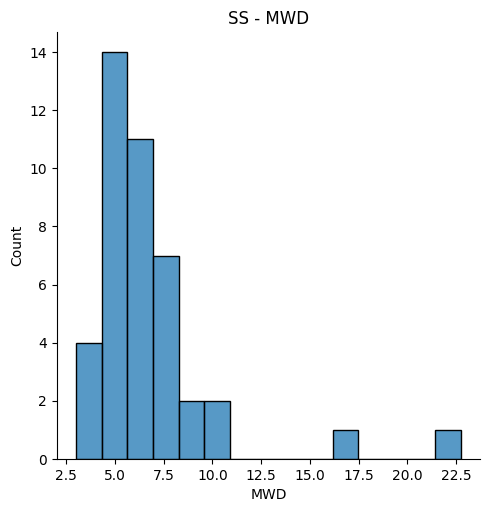

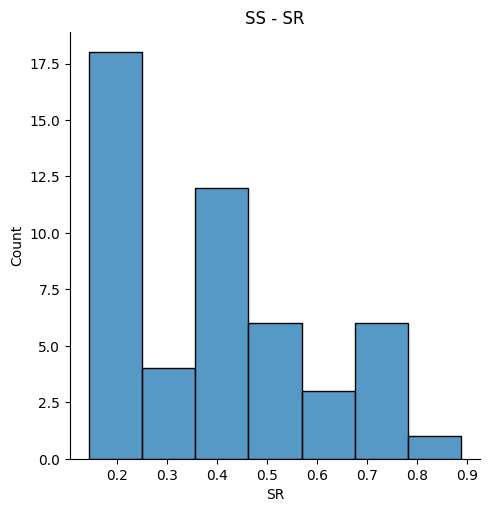

In [94]:

for df in [df_sleep, df_sleepscore]:
    if ('FB_TST' in df.columns): t = 'FB' 
    else: t = 'SS'
    for col in ['SMI', 'MWD', 'SR']:
        sns.displot(df[col])
        plt.title(t + ' - ' + col)
        plt.savefig(f'./../visuals/{t}_{x}.png')

#### Comparing Fitbit and SleepScore data

In [95]:
df_sleep.head()

,Onset,Offset,TST,WASO,NOA,TIB,REMSD,LSD,DSD,Date,TSDP,AI,SWSP,REMP,SMI,MWD,Midpoint,Day,IsWeekend,SR
0,23.183333,7.533333,447.0,54.0,33.0,501.0,80.0,277.0,90.0,2022-10-01,501.0,4.429530,20.134228,17.897092,89.221557,1.636364,4.175000,Saturday,1,NaN
1,22.550000,7.350000,437.0,91.0,32.0,528.0,84.0,297.0,56.0,2022-10-02,528.0,4.393593,12.814645,19.221968,82.765152,2.843750,4.400000,Sunday,1,NaN
2,22.750000,6.866667,426.0,61.0,28.0,487.0,104.0,264.0,58.0,2022-10-03,487.0,3.943662,13.615023,24.413146,87.474333,2.178571,4.058333,Monday,0,0.173672
3,23.150000,6.583333,382.0,64.0,28.0,446.0,53.0,247.0,82.0,2022-10-04,446.0,4.397906,21.465969,13.874346,85.650224,2.285714,3.716667,Tuesday,0,0.285003
4,24.583333,7.250000,352.0,48.0,20.0,400.0,74.0,208.0,70.0,2022-10-05,400.0,3.409091,19.886364,21.022727,88.000000,2.400000,3.916667,Wednesday,0,0.258374


In [96]:
df_sleepscore.head()

,Date,Bedtime,SOL,TST,WASO,Waketime,TIB,NOA,LSD,DSD,...,REMP,SWSP,Onset,Offset,TSDP,MWD,Midpoint,Day,IsWeekend,SR
0,2022-10-01,23.062778,21.0,455.0,32.0,7.529444,508.0,6.0,214.0,152.0,...,19.56,33.41,23.412778,7.529444,487.0,5.333333,4.058333,Saturday,1,NaN
1,2022-10-02,22.387222,19.0,461.0,50.0,7.312222,535.0,9.0,252.0,112.0,...,20.82,24.30,22.703889,7.312222,516.5,5.555556,4.304167,Sunday,1,NaN
2,2022-10-03,22.571667,18.0,447.0,31.0,6.980000,504.0,6.0,246.0,95.0,...,23.71,21.25,22.871667,6.980000,486.5,5.166667,4.054167,Monday,0,0.143150
3,2022-10-04,22.734722,51.0,411.0,22.0,6.884722,489.0,3.0,253.0,126.0,...,7.54,30.66,23.584722,6.884722,438.0,7.333333,3.650000,Tuesday,0,0.270951
4,2022-10-05,24.507500,8.0,378.0,18.0,7.265833,404.0,6.0,185.0,118.0,...,19.58,31.22,24.640833,7.265833,397.5,3.000000,3.953333,Wednesday,0,0.236354


In [97]:
df_sleep.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 56 entries, 0 to 44
Data columns (total 20 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Onset      45 non-null     float64       
 1   Offset     45 non-null     float64       
 2   TST        45 non-null     float64       
 3   WASO       45 non-null     float64       
 4   NOA        45 non-null     float64       
 5   TIB        45 non-null     float64       
 6   REMSD      45 non-null     float64       
 7   LSD        45 non-null     float64       
 8   DSD        45 non-null     float64       
 9   Date       56 non-null     datetime64[ns]
 10  TSDP       45 non-null     float64       
 11  AI         45 non-null     float64       
 12  SWSP       45 non-null     float64       
 13  REMP       45 non-null     float64       
 14  SMI        45 non-null     float64       
 15  MWD        45 non-null     float64       
 16  Midpoint   45 non-null     float64       
 17 

In [98]:
df_sleepscore.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 56 entries, 0 to 41
Data columns (total 28 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       56 non-null     datetime64[ns]
 1   Bedtime    42 non-null     float64       
 2   SOL        42 non-null     float64       
 3   TST        42 non-null     float64       
 4   WASO       42 non-null     float64       
 5   Waketime   42 non-null     float64       
 6   TIB        42 non-null     float64       
 7   NOA        42 non-null     float64       
 8   LSD        42 non-null     float64       
 9   DSD        42 non-null     float64       
 10  REMSD      42 non-null     float64       
 11  ARR        42 non-null     float64       
 12  SS         42 non-null     float64       
 13  MS         42 non-null     float64       
 14  BS         42 non-null     float64       
 15  SE         42 non-null     float64       
 16  SMI        42 non-null     float64       
 17 

report_sleep = ProfileReport(df_sleep, vars={"num": {"low_categorical_threshold": 0}})
report_sleep.to_file('../reports/report_sleep.html')

ax, fig = plt.subplots(figsize=(15, 15))
sns.heatmap(report_sleep.description_set["correlations"]['spearman'], annot=True, cmap="Blues")
x = 'Heatmap'
plt.savefig(f'./../visuals/FB_{x}.png');

report_sleepscore = ProfileReport(df_sleepscore, vars={"num": {"low_categorical_threshold": 0}})
report_sleepscore.to_file('../reports/report_sleepscore.html')

ax, fig = plt.subplots(figsize=(15, 15))
sns.heatmap(report_sleepscore.description_set["correlations"]['spearman'], annot=True, cmap="Blues")
plt.savefig(f'./../visuals/SS_{x}.png');

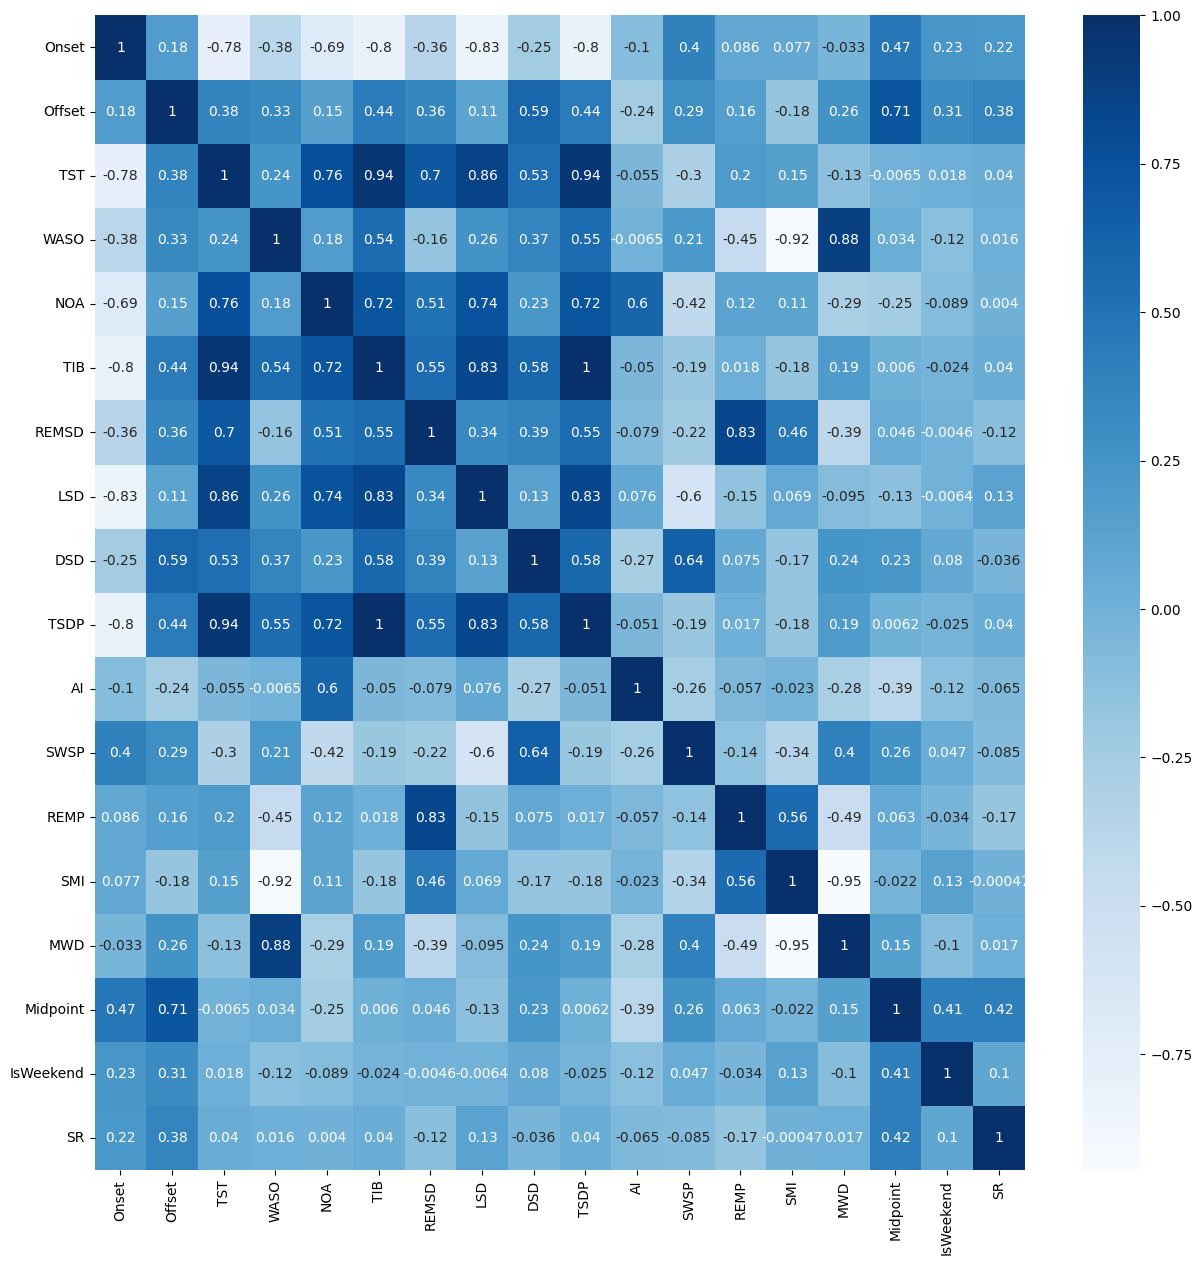

In [99]:
ax, fig = plt.subplots(figsize=(15, 15))
sns.heatmap(df_sleep.corr(), annot=True, cmap='Blues')
x='Heatmap'
plt.savefig(f'./../visuals/FB_{x}.png');

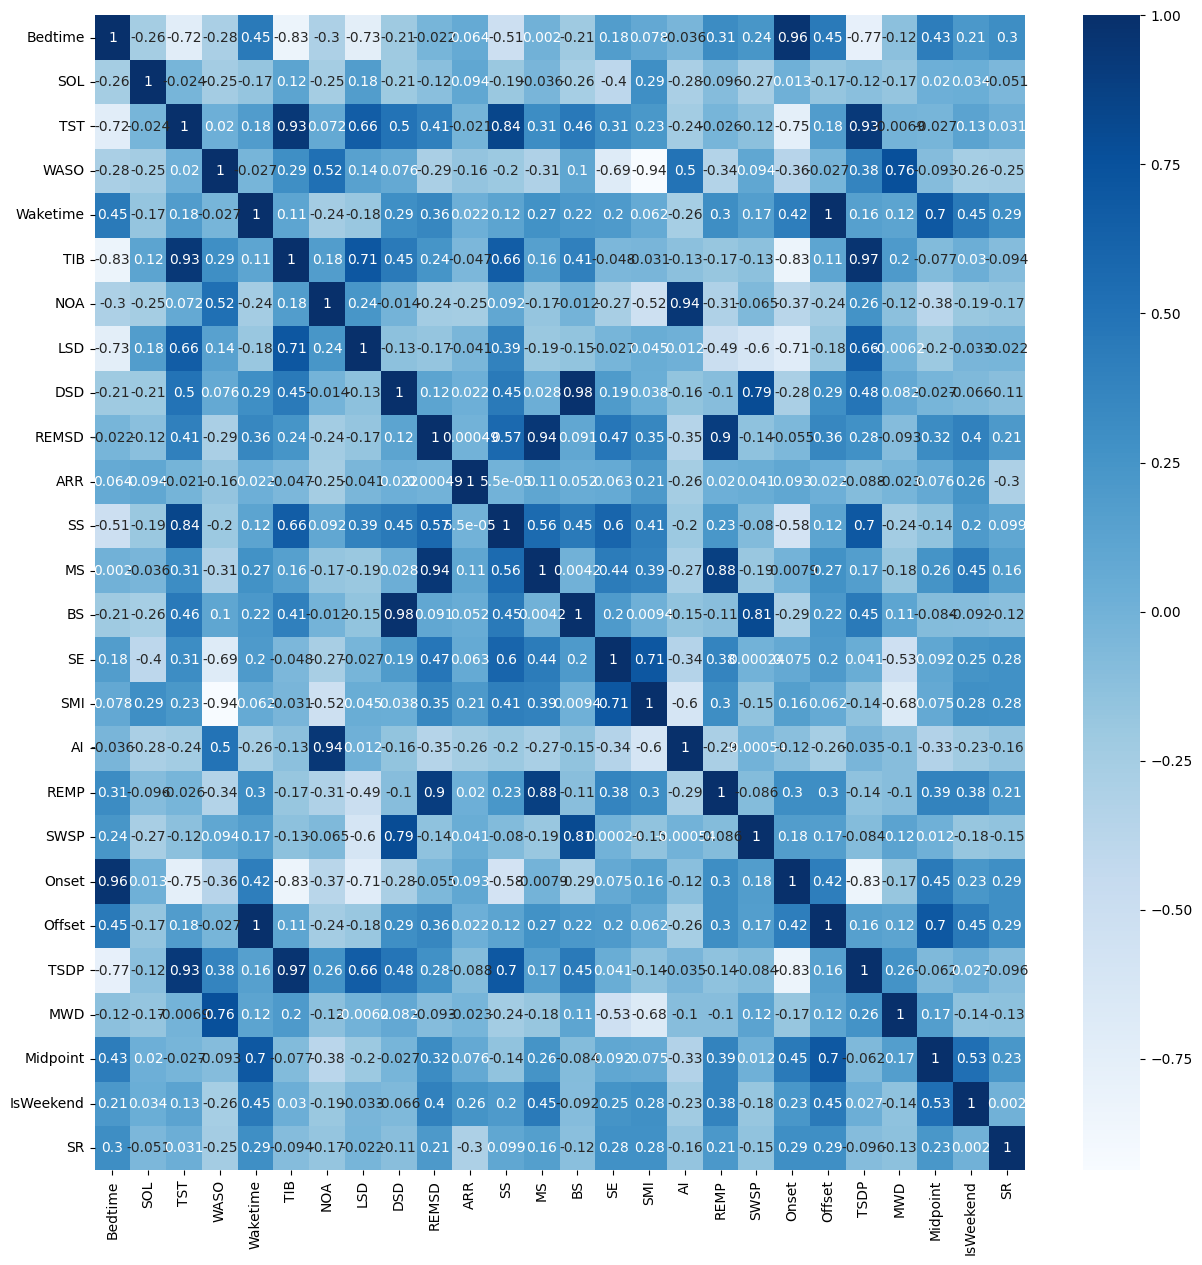

In [100]:
ax, fig = plt.subplots(figsize=(15, 15))
sns.heatmap(df_sleepscore.corr(), annot=True, cmap='Blues')
x='Heatmap'
plt.savefig(f'./../visuals/SS_{x}.png');

There are a few interesting things from the heatmap.
1. Sleep regularity is most correlated with the index. Basically as the index gets bigger so too does sleep regularity measure. This could mean that my sleep is becoming increasingly irregular as the semester goes on.
2. The time I go to bed at or get to sleep at has a strong correlation with how long I sleep for. This is because I always wake up at the same time, so the time I sleep is variable on when I get to bed.

### Logging Data

In [101]:
df_log = df_ss_logging

In [102]:
df_log = df_log.merge(
    pd.date_range(start=df_log.Date.min(),
                  end=df_log.Date.max()
                 ).to_series().reset_index(drop=True).rename('Date'), on='Date', how='outer'
).sort_values('Date').reset_index(drop=True)

In [103]:
df_log.columns = ['Date', 'CaffeineCups', 'AlcoholDrinks', 'Stress', 'Sleepiness', 'PreviousNightMood',
       'GeoLatitude', 'GeoLongitude']

In [104]:
df_log.drop(['GeoLatitude', 'GeoLongitude'], axis=1).head()

,Date,CaffeineCups,AlcoholDrinks,Stress,Sleepiness,PreviousNightMood
0,2022-10-01,0.0,0.0,4.0,4.0,NaN
1,2022-10-02,0.0,0.0,6.0,11.0,NaN
2,2022-10-03,0.0,0.0,13.0,14.0,NaN
3,2022-10-04,0.0,0.0,6.0,8.0,NaN
4,2022-10-05,0.0,1.0,4.0,11.0,NaN


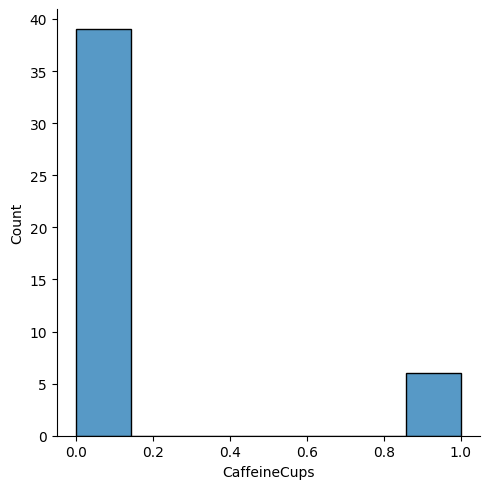

In [105]:
x = 'CaffeineCups'
sns.displot(data=df_log, x=x)
plt.savefig(f'./../visuals/{x}.png');

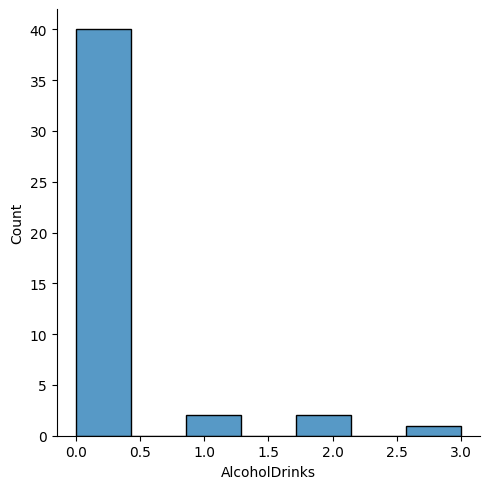

In [106]:
x = 'AlcoholDrinks'
sns.displot(data=df_log, x=x)
plt.savefig(f'./../visuals/{x}.png');

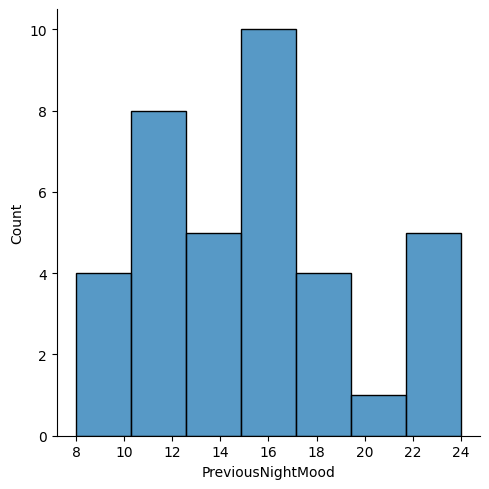

In [107]:
x = 'PreviousNightMood'
sns.displot(data=df_log, x=x)
plt.savefig(f'./../visuals/{x}.png');

In [108]:
df_log.Stress /= 25

In [109]:
df_log['StressR7DM'] = df_log.Stress.rolling(7, 4).mean()

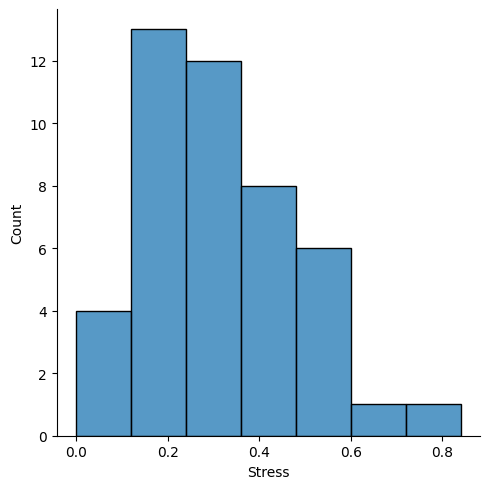

In [110]:
x = 'Stress'
sns.displot(data=df_log, x=x)
plt.savefig(f'./../visuals/{x}.png');

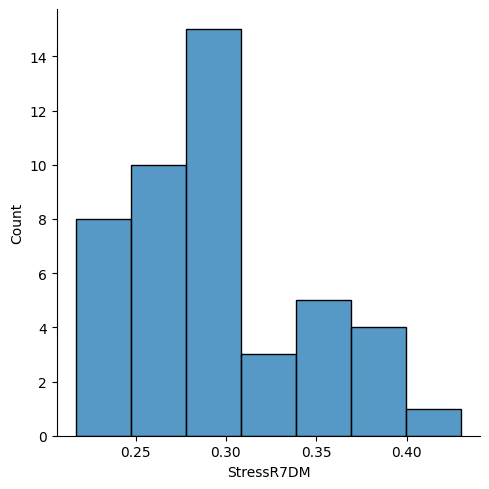

In [111]:
x = 'StressR7DM'
sns.displot(data=df_log, x=x)
plt.savefig(f'./../visuals/{x}.png');

In [112]:
df_log.Sleepiness /= 25

In [113]:
df_log['SleepinessR7DM'] = df_log.Sleepiness.rolling(7, 4).mean()

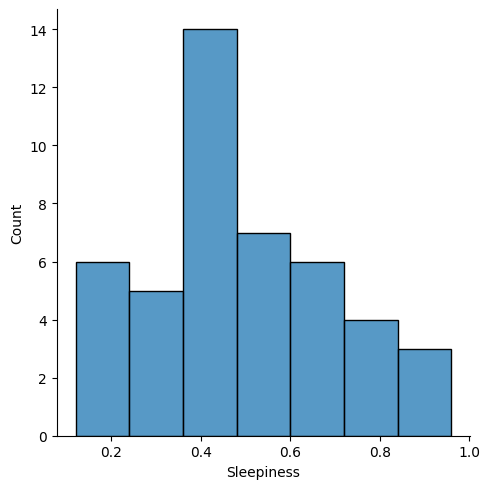

In [114]:
x = 'Sleepiness'
sns.displot(data=df_log, x=x)
plt.savefig(f'./../visuals/{x}.png');

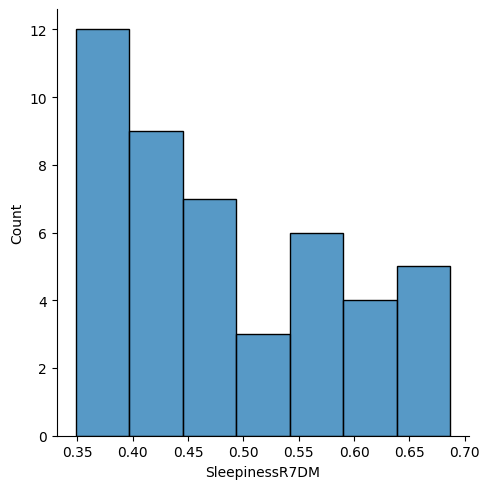

In [115]:
x = 'SleepinessR7DM'
sns.displot(data=df_log, x=x)
plt.savefig(f'./../visuals/{x}.png');

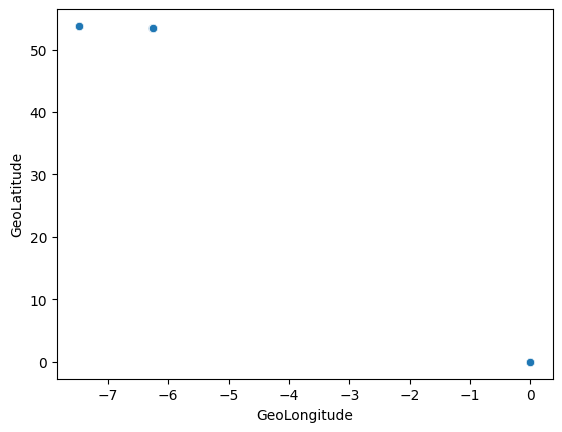

In [116]:
x = 'GeoLongitude'
y = 'GeoLatitude'
sns.scatterplot(data=df_log, x=x, y=y);

In [117]:
df_log.loc[df_log.GeoLongitude == 0]

,Date,CaffeineCups,AlcoholDrinks,Stress,Sleepiness,PreviousNightMood,GeoLatitude,GeoLongitude,StressR7DM,SleepinessR7DM
20,2022-10-21,0.0,3.0,0.44,0.68,12.0,0.0,0.0,0.268571,0.508571
34,2022-11-04,1.0,0.0,0.28,0.44,11.0,0.0,0.0,0.240000,0.448000
35,2022-11-05,0.0,2.0,0.12,0.76,22.0,0.0,0.0,0.220000,0.500000
44,2022-11-14,0.0,0.0,0.28,0.36,14.0,0.0,0.0,0.253333,0.653333
52,2022-11-22,0.0,0.0,0.32,0.80,11.0,0.0,0.0,0.325714,0.428571


Let's create a location based off latitude and longitude. I looked them up on google maps and they are my home and college. The point at 0,0 is an error but we'll consider them to be in college since the dates correspond to weekdays during college.

In [118]:
df_log['AtHome'] = np.where(df_log.GeoLongitude < -7, 1, 0)

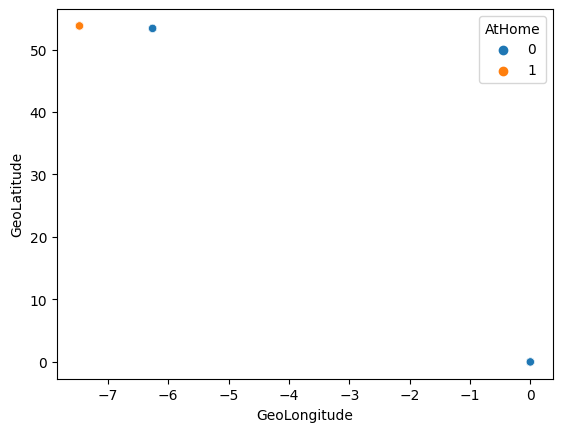

In [119]:
x = 'GeoLongitude'
y = 'GeoLatitude'
z = 'AtHome'
sns.scatterplot(data=df_log, x=x, y=y, hue=z)
plt.savefig(f'./../visuals/{z}.png');

In [120]:
df_log.drop(['GeoLongitude', 'GeoLatitude'], inplace=True, axis=True)

### Mood Data
This data has been pulled from my CBT Thought Diary Account. The data comes in the form of a text document. This means I will have to manually extract the data myself. The text contains very sensitive data, I must be careful not to output  what I have written in the entries.

In [121]:
with open('../data/mood.txt', 'r', encoding="utf8") as f:
    str_mood = ''.join(f.readlines())

In [122]:
# This will group each entry and filter entries that do not contain my mood
list_mood = [entry for entry in str_mood.split('\n------------------\n\n') if 'Mood' in entry]

The best way to deal with this data is to create a function that extracts all the fields from each entry
Most of the function is straight, however at the end I have to replace some values like 'Practicing a Skill' with Projects as that is what I have today on my app.

In [123]:
def extract(entry:str):
    '''
    This function extracts the relevant information from an entry.
    The relevant data includes
        - Date and time: str
        - Mood : str
        - Activities : list
        - Emotions : list
    '''
    # Breaking up each element
    entry = entry.split('\n\n')
    
    # Choosing Date and time, Mood, Activities and Emotions
    entry = entry[0:1] + entry[2:5]
    
    # Removing the prefix for each element
    entry = [x.split(': ')[1] for x in entry]
    
    # Removing the first \n for each list 
    entry[2:] = [x[1:] for x in entry[2:]]
    
    # Converting the strings with \n into lists
    entry[2:] = [x.split('\n') for x in entry[2:]]
    return pd.DataFrame(pd.Series(entry,index=['Datetime', 'Mood', 'Activities', 'Emotions'])).T

In [124]:
df_mood = pd.concat([extract(entry) for entry in list_mood])

In [125]:
df_mood.head()

,Datetime,Mood,Activities,Emotions
0,"25/09/2022, 22:59",Okay,"[Food, Friends, Music]","[Anxious, Guilty, Annoyed, Sad, Tired]"
0,"26/09/2022, 08:04",Okay,"[Self Care, Music]","[Calm, Lonely]"
0,"27/09/2022, 16:04",Good,"[Friends, School]","[Confident, Content, Hopeful, Happy, Excited]"
0,"28/09/2022, 16:28",Okay,[Sleep],[Calm]
0,"28/09/2022, 20:21",Bad,[Love],"[Anxious, Lonely, Sad, Tired]"


In [126]:
df_mood.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 81 entries, 0 to 0
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Datetime    81 non-null     object
 1   Mood        81 non-null     object
 2   Activities  81 non-null     object
 3   Emotions    81 non-null     object
dtypes: object(4)
memory usage: 3.2+ KB


#### Steps to Complete
- Convert Datetime to datetime type and Mood to ordered categorical
- Create Date Column (no time)
- Create Time Column (int)
- Create a Day column
- Create binary variable from Mood
- Create 1 hot encodings from Activities
- Merge Activities columns to reflect current app usage of Activities
- Reduce each day to a single mood (the last mood of the day)
- Filter data between 1/10 and 11/11

In [127]:
# Convert Datetime to datetime
df_mood['Datetime'] = pd.to_datetime(df_mood.Datetime, format='%d/%m/%Y, %H:%M')

# Convert Mood to ordered categorical, a numerical version and binary version
df_mood['Mood'] = pd.Categorical(df_mood.Mood, ['Terrible', 'Bad', 'Okay', 'Good', 'Terrific'], ordered=True)
df_mood['Mood_num'] = df_mood.Mood.cat.codes
df_mood['Mood_bin'] = pd.Categorical(np.where(df_mood.Mood >= 'Good', 'Good', 'Bad'), ['Bad', 'Good'], ordered=True)
df_mood['Mood_bin_num'] = df_mood.Mood_bin.cat.codes

# Create Date column with appropriate format
df_mood['Date'] = pd.to_datetime(df_mood.Datetime.dt.date, format='%Y-%m-%d')

# Create Time Column as float using Datetime
df_mood['Time'] = df_mood.Datetime.dt.hour + df_mood.Datetime.dt.minute / 60

# Create a Day column
df_mood['Day'] = pd.Categorical(df_mood.Datetime.dt.day_name(), 
                                ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
                               )

# Filtering dates for given timeframe
df_mood = df_mood.loc[(first_date <= df_mood.Date) & (df_mood.Date <= last_date)]

# Reduce dataframe to last response of the day
df_mood = df_mood.groupby('Date').last()

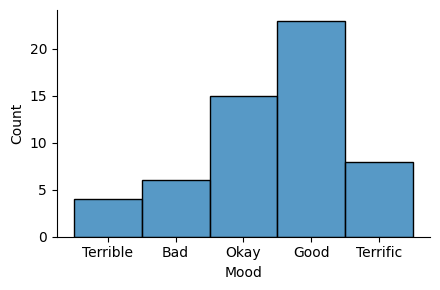

In [128]:
x = 'Mood'
sns.displot(data=df_mood, x=x, height=3, aspect=1.5)
plt.savefig(f'./../visuals/{x}.png');

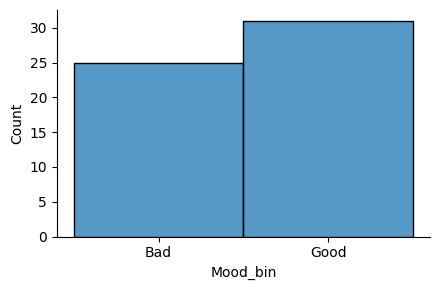

In [129]:
x = 'Mood_bin'
sns.displot(data=df_mood, x=x, height=3, aspect=1.5)
plt.savefig(f'./../visuals/{x}.png');

In [130]:
def CamelCase(s):
    return ''.join([x.capitalize() for x in s.split()])

In [131]:
df_activities = df_mood.Activities.explode().transform(CamelCase)
df_activities.replace('PracticingASkill', 'Projects', inplace=True)
df_activities.replace('Work', 'School', inplace=True)
df_activities.replace('Relax', 'SelfCare', inplace=True)
df_activities.replace('TvAndMovies', 'Entertainment', inplace=True)
df_activities.replace('SocialMedia', 'Entertainment', inplace=True)

In [132]:
# Create one hot encoding and rename columns
df_activities = pd.get_dummies(df_activities).groupby('Date').sum()

# Merge both dataframes together
df_mood = pd.merge(df_mood, df_activities, left_on='Date', right_index=True)

# Dropping Unnecessary columns
df_mood.drop(['Datetime', 'Activities', 'Emotions'], axis=1, inplace=True)

# Reset_index
df_mood.reset_index(inplace=True)

In [133]:
activity = ['Exercise', 'Family',
       'Food', 'Friends', 'Hobby', 'Love', 'NightOut', 'Projects',
       'School', 'SelfCare', 'Sleep', 'Entertainment']
for col in activity:
    df_mood.loc[df_mood[col] > 1, col] = 1

In [134]:
df_mood = pd.merge(df_mood, df_log, on='Date', how='outer')

#### Steps Completed
- ~Convert Datetime to datetime type and Mood to ordered categorical~
- ~Create Date Column (no time)~
- ~Create Time Column (int)~
- ~Create Day column~
- ~Create binary variable from Mood~
- ~Create 1 hot encodings from Activities~
- ~Merge Activities columns to reflect current app usage of Activities~
- ~Reduce each day to a single mood (the last mood of the day)~

In [135]:
df_mood.iloc[:,:20].head()

,Date,Mood,Mood_num,Mood_bin,Mood_bin_num,Time,Day,Entertainment,Exercise,Family,Food,Friends,Hobby,Love,Music,NightOut,Projects,School,SelfCare,Sleep
0,2022-10-01,Okay,2,Bad,0,16.200000,Saturday,0,0,0,0,0,0,0,0,0,0,1,0,0
1,2022-10-02,Bad,1,Bad,0,20.750000,Sunday,0,0,1,0,0,0,0,0,0,0,0,0,0
2,2022-10-03,Terrific,4,Good,1,18.350000,Monday,0,1,1,1,1,1,1,0,0,1,1,1,1
3,2022-10-04,Terrific,4,Good,1,22.733333,Tuesday,0,0,0,0,0,0,1,0,0,0,0,1,0
4,2022-10-05,Okay,2,Bad,0,22.150000,Wednesday,0,0,0,0,0,0,0,0,0,0,1,0,0


In [136]:
df_mood.iloc[:,20:].head()

,CaffeineCups,AlcoholDrinks,Stress,Sleepiness,PreviousNightMood,StressR7DM,SleepinessR7DM,AtHome
0,0.0,0.0,0.16,0.16,NaN,NaN,NaN,1
1,0.0,0.0,0.24,0.44,NaN,NaN,NaN,1
2,0.0,0.0,0.52,0.56,NaN,NaN,NaN,1
3,0.0,0.0,0.24,0.32,NaN,0.290,0.370,0
4,0.0,1.0,0.16,0.44,NaN,0.264,0.384,0


In [137]:
df_mood.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 56 entries, 0 to 55
Data columns (total 28 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Date               56 non-null     datetime64[ns]
 1   Mood               56 non-null     category      
 2   Mood_num           56 non-null     int8          
 3   Mood_bin           56 non-null     category      
 4   Mood_bin_num       56 non-null     int8          
 5   Time               56 non-null     float64       
 6   Day                56 non-null     category      
 7   Entertainment      56 non-null     uint8         
 8   Exercise           56 non-null     uint8         
 9   Family             56 non-null     uint8         
 10  Food               56 non-null     uint8         
 11  Friends            56 non-null     uint8         
 12  Hobby              56 non-null     uint8         
 13  Love               56 non-null     uint8         
 14  Music       

report_mood = ProfileReport(df_mood, vars={"num": {"low_categorical_threshold": 0}})
report_mood.to_file('../reports/report_mood.html')

ax, fig = plt.subplots(figsize=(15, 15))
sns.set(font_scale=1.4)
sns.heatmap(report_mood.description_set["correlations"]['spearman'], annot=True, cmap="rocket_r", annot_kws={"size": 12})

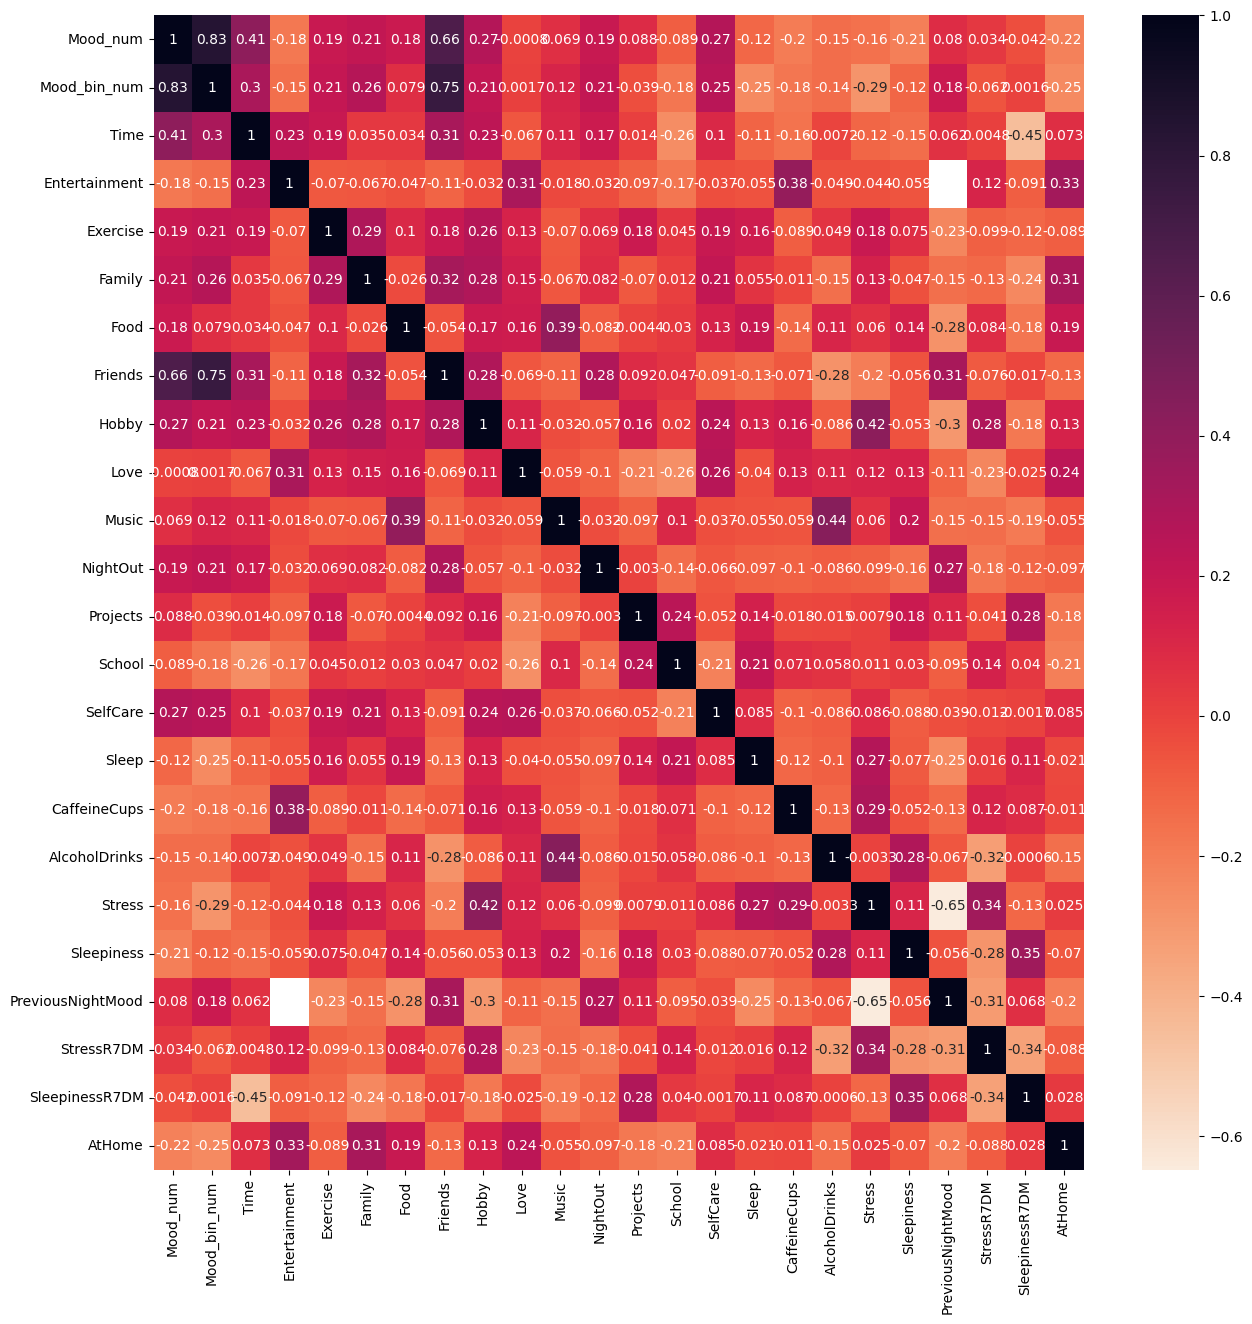

In [138]:
ax, fig = plt.subplots(figsize=(15, 15))
sns.heatmap(df_mood.corr(), annot=True, cmap='rocket_r')
x='Mood_Heatmap'
plt.savefig(f'./../visuals/{x}.png');

### Merge All Data

In [139]:
df_sleep.columns = ['FB_' + col if col not in ['Date', 'Day', 'IsWeekend'] else col for col in df_sleep.columns]
df_sleepscore.columns = ['SS_' + col if col not in ['Date', 'Day', 'IsWeekend'] else col for col in df_sleepscore.columns]

In [140]:
df = pd.merge(df_mood, df_activity, on=['Date', 'Day'], how='outer')
df = pd.merge(df, df_sleep, on=['Date', 'Day'], how='outer')
df = pd.merge(df, df_sleepscore, on=['Date', 'Day', 'IsWeekend'], how='outer')

In [141]:
df.head()

,Date,Mood,Mood_num,Mood_bin,Mood_bin_num,Time,Day,Entertainment,Exercise,Family,...,SS_SMI,SS_AI,SS_REMP,SS_SWSP,SS_Onset,SS_Offset,SS_TSDP,SS_MWD,SS_Midpoint,SS_SR
0,2022-10-01,Okay,2,Bad,0,16.200000,Saturday,0,0,0,...,93.429158,0.79,19.56,33.41,23.412778,7.529444,487.0,5.333333,4.058333,NaN
1,2022-10-02,Bad,1,Bad,0,20.750000,Sunday,0,0,1,...,89.254598,1.17,20.82,24.30,22.703889,7.312222,516.5,5.555556,4.304167,NaN
2,2022-10-03,Terrific,4,Good,1,18.350000,Monday,0,1,1,...,91.880781,0.81,23.71,21.25,22.871667,6.980000,486.5,5.166667,4.054167,0.143150
3,2022-10-04,Terrific,4,Good,1,22.733333,Tuesday,0,0,0,...,93.835616,0.44,7.54,30.66,23.584722,6.884722,438.0,7.333333,3.650000,0.270951
4,2022-10-05,Okay,2,Bad,0,22.150000,Wednesday,0,0,0,...,95.094340,0.95,19.58,31.22,24.640833,7.265833,397.5,3.000000,3.953333,0.236354


In [142]:
df.tail()

,Date,Mood,Mood_num,Mood_bin,Mood_bin_num,Time,Day,Entertainment,Exercise,Family,...,SS_SMI,SS_AI,SS_REMP,SS_SWSP,SS_Onset,SS_Offset,SS_TSDP,SS_MWD,SS_Midpoint,SS_SR
51,2022-11-21,Bad,1,Bad,0,20.633333,Monday,0,1,0,...,95.586381,0.47,18.21,31.13,24.498333,7.106667,396.5,4.666667,3.802500,0.470843
52,2022-11-22,Okay,2,Bad,0,19.016667,Tuesday,0,0,0,...,95.762712,0.40,19.03,29.42,23.594444,7.461111,472.0,6.000000,3.933333,0.462013
53,2022-11-23,Bad,1,Bad,0,18.900000,Wednesday,0,1,0,...,96.404494,0.42,17.48,24.01,23.840278,7.256944,445.0,5.000000,3.708333,0.518290
54,2022-11-24,Okay,2,Bad,0,16.366667,Thursday,0,0,0,...,91.928251,1.17,16.10,28.05,24.091389,7.524722,446.0,4.250000,3.808056,0.487533
55,2022-11-25,Good,3,Good,1,16.333333,Friday,0,0,0,...,89.925769,0.71,18.40,37.50,23.515833,7.374167,471.5,9.200000,3.929167,0.450635


In [143]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 56 entries, 0 to 55
Data columns (total 89 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Date                       56 non-null     datetime64[ns]
 1   Mood                       56 non-null     category      
 2   Mood_num                   56 non-null     int8          
 3   Mood_bin                   56 non-null     category      
 4   Mood_bin_num               56 non-null     int8          
 5   Time                       56 non-null     float64       
 6   Day                        56 non-null     object        
 7   Entertainment              56 non-null     uint8         
 8   Exercise                   56 non-null     uint8         
 9   Family                     56 non-null     uint8         
 10  Food                       56 non-null     uint8         
 11  Friends                    56 non-null     uint8         
 12  Hobby     

In [144]:
df.to_pickle('../data/all.csv')